<h1><center>Data Science Professional Certificate Final Capstone Project</center></h1>
<h2><center>Daniel Liang</center></h2>
<h3><center>Feb 25, 2020</center></h3>

## 1. Introduction/Business Problem

A private investor expects to open a grocery store or supermarket through joining the Loblaw franchises in Ontario, Canada.  Loblaw is the top grocery store and supermarket franchising company in Canada that offers various franchise banners to be used for the independently owned franchise stores across Canada. Details of Loblaw franchise business opportunities can be found in this [link](https://www.loblaw.ca/en/careers/franchise-opportunities.html). 
  
Available franchise banners from Loblaw that are available for selection include
- [No Frills™](https://www.nofrills.ca)
- [Independent City Market™](https://www.independentcitymarket.ca)
- [Fortinos™](https://www.fortinos.ca)
- [Provigo™](https://www.provigo.ca)
- [Valu-Mart™](https://www.valumart.ca)
- [Your Independent Grocer™](https://www.yourindependentgrocer.ca)  

These banners are different from each other and have their own unique features. Simply put, they are tailored for different types of communities or neighborhoods.  

The private investor wants to open a store at a location where one of the banners from the list could be the best fit. Based on the private investor's description and preference, some other specific criteria should be considered when going through the analysis.
1. The best choice of location is Toronto, but still open to other regions in western Ontario including Kitchener-Waterloo-Cambridge (KWC), London, and Windsor.
2. The pick of location and banner should be optimized to avoid harsh competitions within the same area.  

Through this analysis, multiple appropriate locations with optimized selections of banners should be provided to the private investor to support his decision making. From the result, he should get a clearer and detailed insight of the locations and neighborhood features around them so that he can make the best decision about the business strategy.

## 2. Data

###  2.1 Data Understanding

**The first task** of this project is to figure out what differentiate the banners from each other. One of the straightforward strategies is to analyze the products and brands that each banner provides and find out what types of customer targeted by them. In order to do that, scraping the product and brand list for each banner and spending time on understanding the product-customer relationship is unavoidable. This could be extraordinarily time-consuming, and the return on the investment of time may not be satisfying eventually. However, it can be done from another point of view. Since Loblaw's business has been healthy for many years and its strategy of franchise expanding has been tested working by the real market, we have the confidence to believe that the existing locations of those stores have gone through meticulous determination after tremendous analysis performed by either Loblaw's own business teams or other consulting firms. Therefore, by analyzing the location data collected for the neighborhoods around the existing store locations, we are able to tell the uniqueness of each banner based on the similarities or differences of its neighborhood comparing to others. **The second task** is to analyze multiple regions or cities and try to classify their neighborhoods in such a way that the banners are classified. By doing this, we can propose the top and second choices of banners for each of the neighborhoods in those regions of interest. **The last task**, of course, is to help the private investor avoid potential risk of opening a store with duplicated function as one of the existing stores nearby. Competition with similar banners from other franchise companies than Loblaw is allowable.

#### 2.1.1 Store/Banner Address Data
Running for the first task, we need to have a list of locations for the 6 banners. 

In [1]:
# import modules needed for the report

#!pip install --upgrade skit
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup as BS

### --- import 'geocode' packages needed for getting coordinates ---
# uncomment if needed to upgrade pip package 
#!python -m pip install --upgrade pip  

#uncomment to install the pgeocode package - robust for getting coordinates from postal codes
#!pip install pgeocode 
import pgeocode

#uncomment to install the geocoders package - robust for getting coordinates from addresses
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

# import folium maps module
#!conda install -c conda-forge folium=0.5.0 --yes  
import folium 

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!pip install python-docx
from docx import Document

Create a function to save table/dataframe into tables used in word file

In [2]:
def doctable(data, tabletitle, pathfile):
    pathfile = '/'.join(pathfile.split('\\')) # used to handle directory copied from Windows explorer 
    document = Document()
    document.add_heading(tabletitle)
    table = document.add_table(rows=data.shape[0] +1, cols=data.shape[1])  # First row are table headers!
    
    for j in range(data.shape[1]): # add the header row.
        table.cell(0,j).text = data.columns[j]
        
    for i, column in enumerate(data): # add the rest rows.
        for row in range(data.shape[0]) :
            table.cell(row+1, i).text = str(data[column][row])
            
    document.save(pathfile)

Locations of stores can usually be found by using the "store locators" provided by each store's website. Taking [No Frills™ store locator](https://www.nofrills.ca/store-locator?searchQuery=Toronto,%20%E5%AE%89%E5%A4%A7%E7%95%A5%E7%9C%81%E5%8A%A0%E6%8B%BF%E5%A4%A7) for example, by inputing the region as Toronto, it shows all the locations with the corresponding addresses and working hours in the list. However, the temporary searched results, as attempted, are not easy to be scraped by Beautifulsoup pakage in the traditional way. Another approach is found and used here, that is, we can use a website scraping software called [Parsehub](https://www.parsehub.com/). It remembers a sequence of selections and clicks needed for searching on the website before scraping the data outputed from the searches. The tutorial can be referred [here](https://www.parsehub.com/blog/how-to-get-the-locations-of-retail-stores-with-web-scraping/).  

From reading some basic descriptions of the banners, it is found that Provigo™ is only used for retailers based in Quebec. Since Quebec does not fall into the private investor's region of interest, Provigo™ is disregarded from our list. After using Parsehub to scrape the locations data of the rest 5 banners from their store locator website, we obtained 5 csv files containing the information we need for geographical data analysis. 

In [3]:
loc_nofrills_url = 'https://raw.githubusercontent.com/liangyiteng888/Data_Science_Pro_Certificate_Capstone/master/nofrills_loc_results.csv'
loc_indcitymarket_url = 'https://raw.githubusercontent.com/liangyiteng888/Data_Science_Pro_Certificate_Capstone/master/IndependentCityMarket_loc_results.csv'
loc_fortinos_url = 'https://raw.githubusercontent.com/liangyiteng888/Data_Science_Pro_Certificate_Capstone/master/fortinos_loc_results.csv'
loc_valumart_url = 'https://raw.githubusercontent.com/liangyiteng888/Data_Science_Pro_Certificate_Capstone/master/valuemart_loc_results.csv'
loc_yourindgrocer_url = 'https://raw.githubusercontent.com/liangyiteng888/Data_Science_Pro_Certificate_Capstone/master/yourindependentgrocer_loc_results.csv'

loc_nofrills = pd.read_csv(loc_nofrills_url)
loc_indcitymarket = pd.read_csv(loc_indcitymarket_url)
loc_fortinos = pd.read_csv(loc_fortinos_url)
loc_valumart = pd.read_csv(loc_valumart_url)
loc_yourindgrocer = pd.read_csv(loc_yourindgrocer_url)

Now, let's take a look at No Frills and Fortinos data we have obtained.

In [4]:
loc_nofrills.head()
#doctable(loc_nofrills, 'NoFrills Address Data', r'C:\Users\Daniel_Liang\Documents\JupyterNotebook_docs\IBM_DS_Capstone\Report\Tables\Nofrills_Address_Data.docx')

Store_name_Store_name  \
0                       ROCCO'S NOFRILLS TORONTO   
1                        MATT'S NOFRILLS TORONTO   
2                         JOE'S NOFRILLS TORONTO   
3  DAVE & CHARLOTTE'S NOFRILLS TORONTO - GAS BAR   
4            DAVE & CHARLOTTE'S NOFRILLS TORONTO   

                                 Store_name_Address  \
0          200 Front St E, Toronto, Ontario M5A 4T9   
1       449 Parliament St, Toronto, Ontario M5A 3A3   
2  345 Bloor St E Unit 1A, Toronto, Ontario M4W 3J6   
3       449 Carlaw Avenue, Toronto, Ontario M4K 3H9   
4          449 Carlaw Ave, Toronto, Ontario M4K 3H9   

               Store_name_Hours     Store_name_In_store  
0   Closed Now8:00 AM - 9:00 PM  In-Store Shopping Only  
1   Closed Now9:00 AM - 9:00 PM  In-Store Shopping Only  
2   Closed Now8:00 AM - 9:30 PM  In-Store Shopping Only  
3  Closed Now8:00 AM - 10:00 PM  In-Store Shopping Only  
4  Closed Now8:00 AM - 10:00 PM                     NaN

In [5]:
loc_fortinos.head()

Store_name_Store_name                                 Store_name_Address  \
0   NORTH YORK LAWRENCE    700 Lawrence Ave W, North York, Ontario M6A 3B4   
1          QUEENS PLATE   330 Queen's Plate Dr, Etobicoke, Ontario M9W 7J7   
2  HIGHWAY 7 AND ANSLEY          3940 Hwy 7 RR 2, Vaughan, Ontario L4L 9C3   
3             LANGSTAFF      8585 Hwy 27, RR3, Woodbridge, Ontario L4L 1A7   
4       MAJOR MACKENZIE  2911 Major MacKenzie Dr, Vaughan, Ontario L6A 3N9   

            Store_name_Hours Store_name_In_store  
0  Open Now7:00 AM - 8:00 PM                 NaN  
1  Open Now7:00 AM - 8:00 PM                 NaN  
2  Open Now7:00 AM - 8:00 PM                 NaN  
3  Open Now7:00 AM - 8:00 PM                 NaN  
4  Open Now7:00 AM - 8:00 PM                 NaN

These dataframes have to be cleaned and reorganized for our further usage. First, "hours" and "in-store only" features are not very important in our location analysis, so they will be removed from the table. Then, the column names need to be formatted as "Name" and "Address". Second, the "Address" strings may need to be reworded or separated into different columns if necessary. In the data preparation section, coordinates need to be found for these addresses which are going to be passed to **[Foursquare](https://foursquare.com/)** to retrieve location data for further exploratory  analysis.

#### 2.1.2 Neighborhood Address Data
Either for analyzing the neighborhoods  of the store locations found for the banners or the neighborhoods in the private  investor's regions of interest, we need the geographical data around those points of interest. In this analysis, we will only use location data retrieved using **[Foursquare](https://foursquare.com/)** API. The location data from Foursquare only includes information like restaurants, coffee shops, fitness centers, airports, and so on. This location data is good enough to help figure out what type of life in a neighborhood. As a brief analysis, we will not go very deep into analyzing ages, income level, education, population or other demographics. 

Toronto neighborhoods analysis as well as location data can be carried over from this report ([Part 1 - Data](https://github.com/liangyiteng888/Data_Science_Pro_Certificate_Final_Practice/blob/master/Toronto_Neighborhood_Data_Cleaning.ipynb) and [Part 2 - Analysis](https://github.com/liangyiteng888/Data_Science_Pro_Certificate_Final_Practice/blob/master/Toronto_Neighborhood_Modelling.ipynb)), in which the neighborhoods in Toronto are classified into clusters based on the Foursquare location data. We can use the similar  method to analyze Kitchener-Waterloo-Cambridge (KWC), London, and Windsor. The postal codes within these areas can also be found in this [Wikipedia link](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_N). However, unlike Toronto, all of the postal codes in the western Ontario start with 'N', so we need to extract only the codes for the three regions above from the site. **Beautifulsoap** package for data scraping will be used here to handle this task. 

- **Toronto Neighborhood Location Data (Carried over)**

In [6]:
loc_toronto_url = 'https://raw.githubusercontent.com/liangyiteng888/Data_Science_Pro_Certificate_Final_Practice/master/Toronto_Neighborhood_with_Coordinates.csv'
neighbor_toronto = pd.read_csv(loc_toronto_url, index_col=0)
#doctable(neighbor_toronto, 'Toronto Address Data', r'C:\Users\Daniel_Liang\Documents\JupyterNotebook_docs\IBM_DS_Capstone\Report\Tables\Toronto_Address_Data.docx')
neighbor_toronto.head()

Postcode      Borough                            Neighborhood   Latitude  \
0      M1B  Scarborough                          Rouge, Malvern  43.806686   
1      M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2      M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3      M1G  Scarborough                                  Woburn  43.770992   
4      M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

- **Kitchener-Waterloo-Cambridge (KWC), London, and Windsor Location Data**

Use BeautifulSoup package to scrape data from the [wiki website](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_N)

In [7]:
data_wiki_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_N').text
soup = BS(data_wiki_url, 'lxml')
#print(soup.prettify())

In [8]:
neighbor_table = soup.find('table',{'cellpadding':'2'})
#print(neighbor_table)

In [9]:
# define a function to extract values from the scraped wikipedia table
def extract_table_data(sample):
    sample = sample.find('span')
    temp_ls=[]
    temp_surfix = None
    
    for cont in sample.contents:
        try:
            try:
                str = cont.contents[0]
            except:
                str = cont.contents
                if str == []:
                    str = ''
            if not (temp_surfix is None):
                str = temp_surfix + ' ' + str
            temp_ls.append((str + ' '))
            temp_surfix = None
#            print(str)
        except:
            if '/' in cont:
                temp_surfix = cont.strip()
            else:
                str = cont
                if not (temp_surfix is None):
                    str = temp_surfix + ' ' + str
                temp_ls.append(str)
                temp_surfix = None
#    print(temp_ls)                      
    content_name = ''.join(temp_ls).strip()
#    print(content_name)   
    return content_name

In [10]:
neighbor_table = neighbor_table.findAll('td')
neighbor_list=[[],[]]
for row in neighbor_table:
    try:
        neighbor_list[0].append(row.find('b').contents[0])
        neighbor_list[1].append(extract_table_data(row))
    except:
        try:
            neighbor_list[1].append(row.find('i').contents[0])
        except:
            print('check the index of \n', row)
            break
#print(neighbor_list)

Convert the scraped data list into a dataframe which has all of the postal codes in western Ontario. We will clean this dataframe and get coordinates of only the postal codes winthin out regions of interest in the next section.

In [11]:
df_neighbor_roi = pd.DataFrame(np.transpose(neighbor_list), columns = ['Postcode','Region'])
doctable(df_neighbor_roi, 'ROI Address Data', r'C:\Users\Daniel_Liang\Documents\JupyterNotebook_docs\IBM_DS_Capstone\Report\Tables\ROI_Address_Data.docx')
df_neighbor_roi.head()

Postcode                 Region
0      N1A              Dunnville
1      N2A        Kitchener  East
2      N3A  New Hamburg  (Baden )
3      N4A           Not assigned
4      N5A       Stratford  North

### 2.2 Data Preparation - Clean and Find Coordinates
For the scraped data, we need to clean the data and also find the coordinates for the store/banner addresses and neighborhoods in our regions of interest.

#### 2.2.1 Getting Coordinates for Store/Banner Addresses
First, let's clean the stores dataset based on the requirements stated in Section 2.1.1. 

In [12]:
# Save all the store dataframes into one dictionary to make it easier to refer to in the later analysis
dict_store_df = {'nofrills':loc_nofrills, 'indcitymarket':loc_indcitymarket, 'fortinos':loc_fortinos, 'valumart':loc_valumart, 'yourindgrocer':loc_yourindgrocer}
dict_store_df_clean = {}
#dir(dict_store_df)
columns = ['Store Name','Address']
for df_name, df_main in dict_store_df.items():
    df_clean = df_main.iloc[:,0:2].drop_duplicates() # remove duplicated rows
    df_clean.reset_index(drop=True, inplace = True) # reset index
#     print(df_clean)  
    df_clean.columns = columns
    df_clean = df_clean[['Store Name','Address']]
    df_clean['Postcode']=[i[-7:] for i in df_clean['Address']]
    df_clean['Address']=[i[:-7] for i in df_clean['Address']]
    dict_store_df_clean[str(df_name)] = df_clean
    
#dict_store_df_clean['valumart'].head()

Create a function to find coordinates based on the Address column and add the coordinates into the dataframe

In [13]:
def coordinates_in_df_V2(df,postcode_col):
    """
    Read in a dataframe and postal codes in the specified column, then return another dataframe that has two additional columns wiht latitudes and longitudes. Will not change the input dataframe.
    """
    pnomi = pgeocode.Nominatim('ca') # country code 'ca'- Canada
    df_temp = df.copy(deep=True)
    for index, row in df_temp.iterrows():
        try:
            location = pnomi.query_postal_code(str(row[postcode_col]))
        except:
            print('Run terminated due to error!')
            print('Check values in row', index)
            print('Contents of the row:\n', row)
            break
        try:
            #print(location.address)
            #print((location.latitude, location.longitude))
            df_temp.loc[index,'Latitude'] = location.latitude
            df_temp.loc[index,'Longitude'] = location.longitude
        except:
            print('Row', index, "has invalid Address strings that Geolocator doesn't understand and find no coordinates")
            df_temp.loc[index,'Latitude'] = np.nan
            df_temp.loc[index,'Longitude'] = np.nan
            #break
    return df_temp

In [14]:
dict_store_df_ws_coord = {}
for df_name, df_main in dict_store_df_clean.items():
    print('Working on dataframe ', df_name)
    dict_store_df_ws_coord[df_name] = coordinates_in_df_V2(df_main,'Postcode')

Working on dataframe  nofrills
Working on dataframe  indcitymarket
Working on dataframe  fortinos
Working on dataframe  valumart
Working on dataframe  yourindgrocer


Check 'NaN' values in each of the dataframes and make sure we didn't create any after finding the corresponding coordinates

In [15]:
for df_name, df_main in dict_store_df_ws_coord.items():
    print('Dataframe', df_name, ' has number of "Nan":', df_main.isnull().values.sum())

Dataframe nofrills  has number of "Nan": 0
Dataframe indcitymarket  has number of "Nan": 0
Dataframe fortinos  has number of "Nan": 0
Dataframe valumart  has number of "Nan": 0
Dataframe yourindgrocer  has number of "Nan": 0


Take a look at one of the dataframes, No Frills, for example.

In [16]:
dict_store_df_ws_coord['nofrills'].head()

Store Name  \
0                       ROCCO'S NOFRILLS TORONTO   
1                        MATT'S NOFRILLS TORONTO   
2                         JOE'S NOFRILLS TORONTO   
3  DAVE & CHARLOTTE'S NOFRILLS TORONTO - GAS BAR   
4            DAVE & CHARLOTTE'S NOFRILLS TORONTO   

                                     Address Postcode  Latitude  Longitude  
0          200 Front St E, Toronto, Ontario   M5A 4T9   43.6555   -79.3626  
1       449 Parliament St, Toronto, Ontario   M5A 3A3   43.6555   -79.3626  
2  345 Bloor St E Unit 1A, Toronto, Ontario   M4W 3J6   43.6827   -79.3730  
3       449 Carlaw Avenue, Toronto, Ontario   M4K 3H9   43.6803   -79.3538  
4          449 Carlaw Ave, Toronto, Ontario   M4K 3H9   43.6803   -79.3538

Let's combine the banners data together into a single dataframe and create an extra column named "Banner", the "Banner" can be used as the classification tag later in a predictive model

In [17]:
df_store_banner = pd.DataFrame()
for df_store in dict_store_df_ws_coord.items():
    df_store[1]['Banner'] = df_store[0]
    df_store_banner = pd.concat([df_store_banner,df_store[1]])
df_store_banner = df_store_banner.reset_index(drop=True)
df_store_banner

Store Name  \
0                          ROCCO'S NOFRILLS TORONTO   
1                           MATT'S NOFRILLS TORONTO   
2                            JOE'S NOFRILLS TORONTO   
3     DAVE & CHARLOTTE'S NOFRILLS TORONTO - GAS BAR   
4               DAVE & CHARLOTTE'S NOFRILLS TORONTO   
..                                              ...   
126  MORELLO'S YOUR INDEPENDENT GROCER PETERBOROUGH   
127             WILKINSON'S YOUR INDEPENDENT GROCER   
128             TREMBLETT'S YOUR INDEPENDENT GROCER   
129                 GRANT'S YOUR INDEPENDENT GROCER   
130              MCDONALD'S YOUR INDEPENDENT GROCER   

                                             Address Postcode  Latitude  \
0                  200 Front St E, Toronto, Ontario   M5A 4T9   43.6555   
1               449 Parliament St, Toronto, Ontario   M5A 3A3   43.6555   
2          345 Bloor St E Unit 1A, Toronto, Ontario   M4W 3J6   43.6827   
3               449 Carlaw Avenue, Toronto, Ontario   M4K 3H9   43.6803   
4                  449 Carlaw Ave, Toronto, Ontario   M4K 3H9   43.6803   
..                                               ...      ...       ...   
126       400 Lansdowne St E, Peterborough, Ontario   K9L 0B2   44.3552   
127                     227 Main St, Delhi, Ontario   N4B 2N4   42.8501   
128               273 King St W, Ingersoll, Ontario   N5C 2K9   43.0334   
129                  832 Tenth St, Hanover, Ontario   N4N 1S3   44.1501   
130  780 Queen St E, Po Box 220, St Mary's, Ontario   N4X 1B1   43.2655   

     Longitude         Banner  
0     -79.3626       nofrills  
1     -79.3626       nofrills  
2     -79.3730       nofrills  
3     -79.3538       nofrills  
4     -79.3538       nofrills  
..         ...            ...  
126   -78.3199  yourindgrocer  
127   -80.4997  yourindgrocer  
128   -80.8830  yourindgrocer  
129   -81.0330  yourindgrocer  
130   -81.1687  yourindgrocer  

[131 rows x 6 columns]

Notice that there are duplicated coordinates, so let's drop them from the list

In [18]:
df_store_banner_clean = df_store_banner.drop_duplicates(subset=['Latitude','Longitude'], keep = 'last',ignore_index = True)
doctable(df_store_banner_clean, 'Banner Coordinates Data', r'C:\Users\Daniel_Liang\Documents\JupyterNotebook_docs\IBM_DS_Capstone\Report\Tables\Banner_Coord_Data.docx')
df_store_banner_clean.head()

Store Name                               Address  \
0              MATT'S NOFRILLS TORONTO  449 Parliament St, Toronto, Ontario    
1  DAVE & CHARLOTTE'S NOFRILLS TORONTO     449 Carlaw Ave, Toronto, Ontario    
2               JOE'S NOFRILLS TORONTO    900 Dufferin St, Toronto, Ontario    
3           ANTHONY'S NOFRILLS TORONTO     1435 King St W, Toronto, Ontario    
4           LUCIANO'S NOFRILLS TORONTO    243 Alberta Ave, Toronto, Ontario    

  Postcode  Latitude  Longitude    Banner  
0  M5A 3A3   43.6555   -79.3626  nofrills  
1  M4K 3H9   43.6803   -79.3538  nofrills  
2  M6H 4A9   43.6655   -79.4378  nofrills  
3  M6K 1H9   43.6383   -79.4301  nofrills  
4  M6C 3X4   43.6915   -79.4307  nofrills

In [19]:
print('number of each banner in the record before cleaning:\n', df_store_banner['Banner'].value_counts())
print('number of each banner in the record after cleaning:\n', df_store_banner_clean['Banner'].value_counts())

number of each banner in the record before cleaning:
 nofrills         71
valumart         25
fortinos         23
yourindgrocer     9
indcitymarket     3
Name: Banner, dtype: int64
number of each banner in the record after cleaning:
 nofrills         59
fortinos         21
valumart         18
yourindgrocer     9
indcitymarket     3
Name: Banner, dtype: int64


#### 2.2.2 Getting Coordinates for Neighborhoods in Our Regions of Interest (ROI)

In [20]:
print('The original number of records of the ROI neighborhood data is ', df_neighbor_roi.shape[0])
df_neighbor_roi['Region'].value_counts()[:5] # only shows the top five
#df_neighbor_roi['Region'].values

The original number of records of the ROI neighborhood data is  180


Not assigned                                74
Windsor  (City Centre / NW Walkerville )     1
Tecumseh  Outskirts (Windsor )               1
Guelph  East                                 1
Kingsville                                   1
Name: Region, dtype: int64

We notice that out of 180 records, 74 have unassigned region. We'll ignore them from our analysis. 

In [21]:
df_neighbor_roi = df_neighbor_roi[df_neighbor_roi['Region'] != 'Not assigned']
print('The number of records of the data after removing "Not assigned" regions is ', df_neighbor_roi.shape[0])

The number of records of the data after removing "Not assigned" regions is  106


Now, let's clean and reorganize the dataframe so that it has a "Borough" column, in which the values will show whether it is Kitchener-Waterloo-Cambridge (KWC), London, or Windsor. At the mean time, the other boroughs not recognized as the ones in our regions of interest will be noted as 'Nan'. The regions we are going to pick should include the following strings:  
- Kitchener as "KWC"
- Waterloo as "KWC"
- Cambridge as "KWC"
- London
- Windsor

In [22]:
df_neighbor_roi['Borough'] = np.nan
for index, row in df_neighbor_roi.iterrows():
    if any([i in row['Region'] for i in ['Kitchener', 'Waterloo', 'Cambridge']]):
        df_neighbor_roi.loc[index,'Borough'] = 'KWC'
        continue
    elif 'London' in row['Region']:
        df_neighbor_roi.loc[index,'Borough'] = 'London'
        continue
    elif 'Windsor' in row['Region']:
        df_neighbor_roi.loc[index,'Borough'] = 'Windsor'
df_neighbor_roi.head(10)

Postcode                                    Region  Borough
0       N1A                                 Dunnville      NaN
1       N2A                           Kitchener  East      KWC
2       N3A                     New Hamburg  (Baden )      NaN
4       N5A                          Stratford  North      NaN
5       N6A                     London  North  (UWO )   London
6       N7A                                  Goderich      NaN
7       N8A                               Wallaceburg      NaN
8       N9A  Windsor  (City Centre / NW Walkerville )  Windsor
10      N2B                      Kitchener  Northeast      KWC
11      N3B                                    Elmira      NaN

Now, let's remove the "Borough" rows with 'NaN' so that regions not in our interest will be discarded, and reindex the dataframe.

In [23]:
df_neighbor_roi_clean = df_neighbor_roi.dropna()
print('The final number of records is ', df_neighbor_roi_clean.shape[0])
df_neighbor_roi_clean.head()

The final number of records is  56


Postcode                                    Region  Borough
1       N2A                           Kitchener  East      KWC
5       N6A                     London  North  (UWO )   London
8       N9A  Windsor  (City Centre / NW Walkerville )  Windsor
10      N2B                      Kitchener  Northeast      KWC
14      N6B                           London  Central   London

It's time to find the coordinates for the neighborhoods(postcodes) in our list. The 'pgeocode' package is used here by following this [instruction](https://pypi.org/project/pgeocode/).

In [24]:
df_neighbor_roi_clean = df_neighbor_roi_clean.copy(deep=True) # reset the memory locatoin of the dataframe to avoid the copy warning message
df_neighbor_roi_clean['Latitude']=''
df_neighbor_roi_clean['Longitude']=''
pnomi = pgeocode.Nominatim('ca') # country code 'ca'- Canada
for index, row in df_neighbor_roi_clean.iterrows():   
    geoloc=pnomi.query_postal_code(str(row['Postcode'])) 
    #print(geoloc['latitude']:'longitude'])
    df_neighbor_roi_clean.loc[index,'Latitude'] = geoloc['latitude']
    df_neighbor_roi_clean.loc[index,'Longitude'] = geoloc['longitude']
df_neighbor_roi_clean.head()

Postcode                                    Region  Borough Latitude  \
1       N2A                           Kitchener  East      KWC  43.4413   
5       N6A                     London  North  (UWO )   London  42.9976   
8       N9A  Windsor  (City Centre / NW Walkerville )  Windsor  42.2007   
10      N2B                      Kitchener  Northeast      KWC  43.4646   
14      N6B                           London  Central   London  42.9835   

   Longitude  
1   -80.4246  
5   -81.2563  
8   -83.0276  
10  -80.4467  
14  -81.2386

We can group our data so that rows with the same Borough stay together, and let's also put the Borough column ahead of the Region column. Notice the difference from the Toronto neighborhood data that the data collected for these regions of interest do not have detailed information like 'Borough' or 'Neighborhood' given by the website directly. We will just call the Regions as 'Neighborhood' from now on.

In [25]:
df_neighbor_roi_grouped = df_neighbor_roi_clean[['Postcode', 'Borough', 'Region']+df_neighbor_roi_clean.columns.to_list()[-2:]]
df_neighbor_roi_grouped.rename(columns={'Region':'Neighborhood'},inplace=True)
df_neighbor_roi_grouped = df_neighbor_roi_grouped.sort_values(by = 'Borough').reset_index(drop=True)
print('Check the number of records is ', df_neighbor_roi_grouped.shape[0])
doctable(df_neighbor_roi_grouped, 'ROI Coordinates Data', r'C:\Users\Daniel_Liang\Documents\JupyterNotebook_docs\IBM_DS_Capstone\Report\Tables\ROI_Coord_Data.docx')
df_neighbor_roi_grouped

Check the number of records is  56


Postcode  Borough                                       Neighborhood  \
0       N2A      KWC                                    Kitchener  East   
1       N2V      KWC                                Waterloo  Northwest   
2       N2T      KWC                                Waterloo  Southwest   
3       N1T      KWC                                    Cambridge  East   
4       N1S      KWC                               Cambridge  Southwest   
5       N2R      KWC                                   Kitchener  South   
6       N1R      KWC                                 Cambridge  Central   
7       N2P      KWC                               Kitchener  Southeast   
8       N1P      KWC                                   Cambridge  South   
9       N2N      KWC                                    Kitchener  West   
10      N2M      KWC                               Kitchener  Northwest   
11      N2K      KWC                                     Waterloo  East   
12      N2J      KWC                                Waterloo  Southeast   
13      N3H      KWC                                    Cambridge  West   
14      N2H      KWC                           Kitchener  North Central   
15      N2L      KWC                                    Waterloo  South   
16      N3C      KWC                               Cambridge  Northeast   
17      N2G      KWC                                 Kitchener  Central   
18      N2B      KWC                               Kitchener  Northeast   
19      N3E      KWC                               Cambridge  Northwest   
20      N2C      KWC                           Kitchener  South Central   
21      N2E      KWC                               Kitchener  Southwest   
22      N5Y   London            London  (West Huron Heights / Carling )   
23      N5X   London  London  (Fanshawe / Stoneybrook / Stoney Creek...   
24      N5W   London         London  East  (SW Argyle / Hamilton Road )   
25      N5V   London  London  (YXU / North and East Argyle / East Hu...   
26      N6A   London                              London  North  (UWO )   
27      N6B   London                                    London  Central   
28      N6P   London  London  (Talbot / Lambeth / West Tempo / South...   
29      N6G   London  London  (Sunningdale / West Masonville / Medwa...   
30      N6C   London  London  South  (East Highland / North White Oa...   
31      N6N   London  London  (South Highbury / Glanworth / East Bro...   
32      N5Z   London                              London  (Glen Cairn )   
33      N6M   London  London  (Jackson / Old Victoria / Bradley / No...   
34      N6L   London                              London  (East Tempo )   
35      N6H   London      London  West  (Central Hyde Park / Oakridge )   
36      N6K   London  London  (Riverbend / Woodhull / North Sharon C...   
37      N6E   London  London  (South White Oaks / Central Westminste...   
38      N6J   London  London  (Southcrest / East Westmount / West Hi...   
39      N8N  Windsor                     Tecumseh  Outskirts (Windsor )   
40      N9E  Windsor                     Windsor  South  (East Malden )   
41      N8X  Windsor  Windsor  South Central  (West Walkerville / Re...   
42      N8W  Windsor  Windsor  (South Walkerville / West Fontainbleu...   
43      N9H  Windsor                           LaSalle  East (Windsor )   
44      N8V  Windsor                                    Windsor  (YQG )   
45      N9A  Windsor           Windsor  (City Centre / NW Walkerville )   
46      N9C  Windsor       Windsor  (Sandwich / Ojibway / West Malden )   
47      N9J  Windsor                          La Salle  West (Windsor )   
48      N8S  Windsor                              Windsor  (Riverside )   
49      N8R  Windsor                      Windsor  (East Forest Glade )   
50      N9B  Windsor             Windsor  (University / South Cameron )   
51      N9K  Windsor                                            Windsor   
52      N8P  Windsor        

Let's save the cleaned data into a csv file for later analysis. In the next, this coordinates data will be used through Foursquare API to retrieve location data for exploratory analysis. 

In [26]:
#df_neighbor_roi_grouped.to_csv('roi_neighbor_cleaned.csv')

### 2.3 Data Preparation - Location Data through FourSquare

#### 2.3.1 Store(Banner) Location Data

In [27]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [28]:
# create map of Toronto  using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the stores
x = np.arange(len(dict_store_df_ws_coord.keys()))
ys = [i + x + (i*x)**2 for i in range(len(dict_store_df_ws_coord.keys()))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = {k:colors.rgb2hex(v) for (k,v) in zip(dict_store_df_ws_coord.keys(),colors_array)}

## add store markers to map
for lat, lng, store_loc_name, banner in zip(df_store_banner_clean['Latitude'], df_store_banner_clean['Longitude'], df_store_banner_clean['Store Name'], df_store_banner_clean['Banner']):
     label = '{} ({})'.format(store_loc_name, banner)
     label = folium.Popup(label, parse_html=True)
     folium.CircleMarker(
          [lat, lng],
          radius=7,
         popup=label,
         color=rainbow[banner],
         fill=True,
         fill_color='#3186cc',
         fill_opacity=0.5,
         parse_html=False).add_to(map_toronto)  
map_toronto.save('Store_location_folium.png')    
map_toronto

Define Foursquare Credentials and Version

In [29]:
CLIENT_ID = 'UFVBX0AITYQGIOHCTKAXCAOREBEZYWFR55WFJZ1DDAEZ53L2' # your Foursquare ID
CLIENT_SECRET = 'BV20PKRLNZGAQRMFGOIRNXE4MTBQ3NENGIRN01DXIR5PC3UE' # your Foursquare Secret
VERSION = '20200301' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UFVBX0AITYQGIOHCTKAXCAOREBEZYWFR55WFJZ1DDAEZ53L2
CLIENT_SECRET:BV20PKRLNZGAQRMFGOIRNXE4MTBQ3NENGIRN01DXIR5PC3UE


Create a function to get venues for store locations 

In [30]:
def getNearbyVenues(names, banners, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, banner, lat, lng in zip(names, banners, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            banner,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Banner',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get venues and drop records where the 'Venue Category' is indicated as 'Neighborhood'

In [31]:
LIMIT= 100
radius = 200
store_venues = getNearbyVenues(df_store_banner_clean['Store Name'],df_store_banner_clean['Banner'], df_store_banner_clean['Latitude'],df_store_banner_clean['Longitude'])
store_venues = store_venues.drop(store_venues[['Neighborhood' in i for i in store_venues['Venue Category']]].index).reset_index(drop = True)

MATT'S NOFRILLS TORONTO
DAVE & CHARLOTTE'S NOFRILLS TORONTO
JOE'S NOFRILLS TORONTO
ANTHONY'S NOFRILLS TORONTO
LUCIANO'S NOFRILLS TORONTO
ROCCA'S NOFRILLS TORONTO
TIM & SUE'S NOFRILLS TORONTO
JASON'S NOFRILLS TORONTO
NICHOLSON’S NOFRILLS TORONTO
SAM & NANCY'S NOFRILLS TORONTO
DINO'S NOFRILLS TORONTO
TOM'S NOFRILLS EAST YORK
ANDREW & SHELLEY’S NOFRILLS NORTH YORK
ALI'S NOFRILLS
LEONETTI'S NOFRILLS NORTH YORK
JIM & MARIA'S NOFRILLS TORONTO
NICK & MIRA'S NOFRILLS NORTH YORK
ROD & JOE'S NOFRILLS SCARBOROUGH
CARLO'S NOFRILLS NORTH YORK
ROB'S NOFRILLS SCARBOROUGH
EMILIANO & ANA'S NOFRILLS ETOBICOKE
VITO'S NOFRILLS NORTH YORK
JEFF, ROSE & HERB'S NOFRILLS ETOBICOKE
STEPHEN'S NOFRILLS SCARBOROUGH
LISTRO'S NOFRILLS NORTH YORK
CHRIS' NOFRILLS ETOBICOKE
CARLO'S NOFRILLS NORTH YORK
DURANTE'S NOFRILLS NORTH YORK
NICK'S NOFRILLS SCARBOROUGH
CHRIS & STACEY'S NOFRILLS MISSISSAUGA
DAVE'S NOFRILLS SCARBOROUGH
ANTHONY'S NOFRILLS VAUGHAN
DINO'S NOFRILLS MISSISSAUGA
SHERIFF'S NOFRILLS ETOBICOKE
MARC'S NOFRIL

In [32]:
store_venues.head()

Neighborhood    Banner  Neighborhood Latitude  \
0  MATT'S NOFRILLS TORONTO  nofrills                43.6555   
1  MATT'S NOFRILLS TORONTO  nofrills                43.6555   
2  MATT'S NOFRILLS TORONTO  nofrills                43.6555   
3  MATT'S NOFRILLS TORONTO  nofrills                43.6555   
4  MATT'S NOFRILLS TORONTO  nofrills                43.6555   

   Neighborhood Longitude                   Venue  Venue Latitude  \
0                -79.3626           Tandem Coffee       43.653559   
1                -79.3626        Roselle Desserts       43.653447   
2                -79.3626  Figs Breakfast & Lunch       43.655675   
3                -79.3626     Body Blitz Spa East       43.654735   
4                -79.3626        Cocina Economica       43.654959   

   Venue Longitude      Venue Category  
0       -79.361809         Coffee Shop  
1       -79.362017              Bakery  
2       -79.364503      Breakfast Spot  
3       -79.359874                 Spa  
4       -79.365657  Mexican Restaurant

In [33]:
store_venues_count = store_venues.groupby('Neighborhood')['Venue'].count().reset_index(name = 'Number of venues')

store_venues_count_sort = store_venues_count.sort_values(by = 'Number of venues', ascending = False).reset_index(drop=True)
store_venues_categories = store_venues.groupby('Venue Category')[['Venue']].count().sort_values(by='Venue',ascending=False).reset_index().head(10)
doctable(store_venues_count_sort, 'Store Venues Count', r'C:\Users\Daniel_Liang\Documents\JupyterNotebook_docs\IBM_DS_Capstone\Report\Tables\store_venues_count.docx')
doctable(store_venues_categories, 'Store Venues Categories', r'C:\Users\Daniel_Liang\Documents\JupyterNotebook_docs\IBM_DS_Capstone\Report\Tables\store_venues_Categories.docx')

store_venues_count

Neighborhood  Number of venues
0                            ALI'S NOFRILLS                11
1    ANDREW & SHELLEY’S NOFRILLS NORTH YORK                 7
2                ANTHONY'S NOFRILLS TORONTO                38
3                ANTHONY'S NOFRILLS VAUGHAN                14
4             ASHLEY'S NOFRILLS MISSISSAUGA                 4
..                                      ...               ...
89                 VINCE'S NOFRILLS VAUGHAN                 4
90              VISCONTI'S NOFRILLS MARKHAM                 5
91               VITO'S NOFRILLS NORTH YORK                 6
92  VOS' YOUR INDEPENDENT GROCER PORT PERRY                 6
93      WILKINSON'S YOUR INDEPENDENT GROCER                 5

[94 rows x 2 columns]

In [34]:
print('There are {} unique categories.'.format(len(store_venues['Venue Category'].unique())))

There are 214 unique categories.


#### Transform the venue categories for each store/banner to be applicable for clustering/classification
Use one hot encoding to transform the venue categories into 0/1 numbers needed as input for the clustering modelling

In [35]:
# one hot encoding
store_onehot = pd.get_dummies(store_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
store_onehot['Neighborhood'] = store_venues['Neighborhood'] 
store_onehot['Banner'] = store_venues['Banner'] 

# move neighborhood column to the first column
fixed_columns = list(store_onehot.columns[-2:]) + list(store_onehot.columns[:-2])
store_onehot = store_onehot[fixed_columns]
#print(fixed_columns)
print(store_onehot.shape)
store_onehot.head()

(990, 216)


Neighborhood    Banner  Accessories Store  American Restaurant  \
0  MATT'S NOFRILLS TORONTO  nofrills                  0                    0   
1  MATT'S NOFRILLS TORONTO  nofrills                  0                    0   
2  MATT'S NOFRILLS TORONTO  nofrills                  0                    0   
3  MATT'S NOFRILLS TORONTO  nofrills                  0                    0   
4  MATT'S NOFRILLS TORONTO  nofrills                  0                    0   

   Antique Shop  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0             0            0                    0                 0   
1             0            0                    0                 0   
2             0            0                    0                 0   
3             0            0                    0                 0   
4             0            0                    0                 0   

   Astrologer  Athletics & Sports  ...  Vegetarian / Vegan Restaurant  \
0           0                   0  ...                              0   
1           0                   0  ...                              0   
2           0                   0  ...                              0   
3           0                   0  ...                              0   
4           0                   0  ...                              0   

   Veterinarian  Video Game Store  Video Store  Vietnamese Restaurant  \
0             0                 0            0                      0   
1             0                 0            0                      0   
2             0                 0            0                      0   
3             0                 0            0                      0   
4             0                 0            0                      0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0         0          0            0              0            0  
1         0          0            0              0            0  
2         0          0            0              0            0  
3         0          0            0              0            0  
4         0          0            0              0            0  

[5 rows x 216 columns]

In [36]:

# store_onehot_example = store_onehot[['Neighborhood', 'Banner'] + store_venues_categories['Venue Category'].to_list()]#.head(10)
# [store_onehot_example[store_onehot_example.columns[2:]].sum(1)]
#store_onehot_example = store_onehot_example[sum(i)>3 for i in store_onehot_example[store_onehot_example.columns[2:]]]
# store_onehot_example

#### 2.3.2 ROI Location Data

In [37]:
address = 'London, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 42.9836747, -81.2496068.


In [38]:
# create map of Toronto  using latitude and longitude values
map_west_ON = folium.Map(location=[latitude, longitude], zoom_start=8)

## add ROI markers to map
for lat, lng, roi_neighbor_name, borough in zip(df_neighbor_roi_grouped['Latitude'], df_neighbor_roi_grouped['Longitude'], df_neighbor_roi_grouped['Neighborhood'], df_neighbor_roi_grouped['Borough']):
     label = '{} ({})'.format(roi_neighbor_name, borough)
     label = folium.Popup(label, parse_html=True)
     folium.CircleMarker(
          [lat, lng],
          radius=7,
         popup=label,
         color='yellow',
         fill=True,
         fill_color='blue',
         fill_opacity=0.5,
         parse_html=False).add_to(map_west_ON)  
map_toronto.save('ROI_location_folium.html')    
map_west_ON

In [39]:
LIMIT= 100
radius = 200
ROI_venues = getNearbyVenues(df_neighbor_roi_grouped['Neighborhood'],df_neighbor_roi_grouped['Borough'],df_neighbor_roi_grouped['Latitude'],df_neighbor_roi_grouped['Longitude'])
ROI_venues = ROI_venues.drop(ROI_venues[['Neighborhood' in i for i in ROI_venues['Venue Category']]].index).reset_index(drop = True)

Kitchener  East
Waterloo  Northwest
Waterloo  Southwest
Cambridge  East
Cambridge  Southwest
Kitchener  South
Cambridge  Central
Kitchener  Southeast
Cambridge  South
Kitchener  West
Kitchener  Northwest
Waterloo  East
Waterloo  Southeast
Cambridge  West
Kitchener  North Central
Waterloo  South
Cambridge  Northeast
Kitchener  Central
Kitchener  Northeast
Cambridge  Northwest
Kitchener  South Central
Kitchener  Southwest
London  (West Huron Heights / Carling )
London  (Fanshawe / Stoneybrook / Stoney Creek / Uplands / East Masonville )
London  East  (SW Argyle / Hamilton Road )
London  (YXU / North and East Argyle / East Huron Heights )
London  North  (UWO )
London  Central
London  (Talbot / Lambeth / West Tempo / South Sharon Creek )
London  (Sunningdale / West Masonville / Medway / NE Hyde Park / East Fox Hollow )
London  South  (East Highland / North White Oaks / North Westminster )
London  (South Highbury / Glanworth / East Brockley / SE Westminster )
London  (Glen Cairn )
London  (

In [40]:
ROI_venues.head()

Neighborhood Banner  Neighborhood Latitude  Neighborhood Longitude  \
0      Kitchener  East    KWC                43.4413                -80.4246   
1  Waterloo  Northwest    KWC                43.4764                -80.5842   
2  Waterloo  Northwest    KWC                43.4764                -80.5842   
3  Waterloo  Northwest    KWC                43.4764                -80.5842   
4  Waterloo  Southwest    KWC                43.4530                -80.5692   

                                Venue  Venue Latitude  Venue Longitude  \
0           Leafs Lounge and Beer Den       43.441344       -80.425994   
1  Tri-city RC club field (Erbsville)       43.479130       -80.586803   
2          Laurel Creek Nature Centre       43.474507       -80.588945   
3                      Hollyview Park       43.472500       -80.586000   
4                   GRT Bus Stop 3693       43.456571       -80.571682   

         Venue Category  
0            Sports Bar  
1             Racetrack  
2  Other Great Outdoors  
3                  Park  
4              Bus Stop

In [41]:
ROI_venues_count = ROI_venues.groupby('Neighborhood')['Venue'].count().reset_index(name = 'Number of venues')

ROI_venues_count_sort = ROI_venues_count.sort_values(by = 'Number of venues', ascending = False).reset_index(drop=True)
ROI_venues_categories = ROI_venues.groupby('Venue Category')[['Venue']].count().sort_values(by='Venue',ascending=False).reset_index().head(10)
doctable(ROI_venues_count_sort, 'ROI Venues Count', r'C:\Users\Daniel_Liang\Documents\JupyterNotebook_docs\IBM_DS_Capstone\Report\Tables\ROI_venues_count.docx')
doctable(ROI_venues_categories, 'ROI Venues Categories', r'C:\Users\Daniel_Liang\Documents\JupyterNotebook_docs\IBM_DS_Capstone\Report\Tables\ROI_venues_Categories.docx')

ROI_venues_count

Neighborhood  Number of venues
0                                    Cambridge  South                 2
1                                Cambridge  Southwest                 1
2                                     Cambridge  West                 3
3                                  Kitchener  Central                 4
4                                     Kitchener  East                 1
5                            Kitchener  North Central                 8
6                                Kitchener  Northeast                 2
7                                Kitchener  Northwest                28
8                                    Kitchener  South                 4
9                            Kitchener  South Central                42
10                               Kitchener  Southwest                 4
11                                    Kitchener  West                 4
12                          La Salle  West (Windsor )                 1
13                           LaSalle  East (Windsor )                 1
14                              London  (East Tempo )                 1
15  London  (Riverbend / Woodhull / North Sharon C...                 2
16  London  (Southcrest / East Westmount / West Hi...                 3
17  London  (Sunningdale / West Masonville / Medwa...                 4
18            London  (West Huron Heights / Carling )                 3
19  London  (YXU / North and East Argyle / East Hu...                 3
20                                    London  Central                19
21         London  East  (SW Argyle / Hamilton Road )                 2
22                              London  North  (UWO )                15
23  London  South  (East Highland / North White Oa...                 5
24      London  West  (Central Hyde Park / Oakridge )                 2
25                     Tecumseh  Outskirts (Windsor )                 2
26                                     Waterloo  East                 4
27                                Waterloo  Northwest                 3
28                                    Waterloo  South                19
29                                Waterloo  Southeast                21
30                                Waterloo  Southwest                 2
31                                            Windsor                 2
32                      Windsor  (East Forest Glade )                 6
33                         Windsor  (East Riverside )                 1
34                              Windsor  (Riverside )                 1
35                               Windsor  (Roseland )                 4
36  Windsor  (South Walkerville / West Fontainbleu...                 4
37             Windsor  (University / South Cameron )                 5
38   Windsor  (West Forest Glade / East Fontainbleu )                 4
39                  Windsor  East (East Walkerville )                 5
40                     Windsor  South  (East Malden )                 5
41  Windsor  South Central  (West Walkerville / Re...                 4

In [42]:
print('There are {} unique categories.'.format(len(ROI_venues['Venue Category'].unique())))

There are 114 unique categories.


#### Transform the venue categories for each ROI to be applicable for clustering/classification

In [43]:
# one hot encoding
ROI_onehot = pd.get_dummies(ROI_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ROI_onehot['Neighborhood'] = ROI_venues['Neighborhood'] 
ROI_onehot['Borough'] = ROI_venues['Banner'] 

# move neighborhood column to the first column
fixed_columns = list(ROI_onehot.columns[-2:]) + list(ROI_onehot.columns[:-2])
ROI_onehot = ROI_onehot[fixed_columns]
#print(fixed_columns)
print(ROI_onehot.shape)
ROI_onehot.head()

(256, 116)


Neighborhood Borough  Adult Boutique  American Restaurant  \
0      Kitchener  East     KWC               0                    0   
1  Waterloo  Northwest     KWC               0                    0   
2  Waterloo  Northwest     KWC               0                    0   
3  Waterloo  Northwest     KWC               0                    0   
4  Waterloo  Southwest     KWC               0                    0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Baby Store  Bakery  ...  Toy / Game Store  Trail  Tree  Tunnel  \
0           0       0  ...                 0      0     0       0   
1           0       0  ...                 0      0     0       0   
2           0       0  ...                 0      0     0       0   
3           0       0  ...                 0      0     0       0   
4           0       0  ...                 0      0     0       0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Vineyard  \
0                              0                      0         0   
1                              0                      0         0   
2                              0                      0         0   
3                              0                      0         0   
4                              0                      0         0   

   Wings Joint  Women's Store  Yoga Studio  
0            0              0            0  
1            0              0            0  
2            0              0            0  
3            0              0            0  
4            0              0            0  

[5 rows x 116 columns]

## 3. Exploratory Data Analysis
### 3.1 Store(Banner) Venues Analysis

In [44]:
# store_venue_grouped = store_onehot.groupby(by=['Neighborhood','Banner']).mean().reset_index()
store_venue_grouped = store_onehot.groupby(by=['Banner']).mean().reset_index()
print(store_venue_grouped.shape)
store_venue_grouped.head()

(5, 215)


Banner  Accessories Store  American Restaurant  Antique Shop  \
0       fortinos           0.005556             0.016667      0.000000   
1  indcitymarket           0.000000             0.000000      0.000000   
2       nofrills           0.001792             0.003584      0.001792   
3       valumart           0.000000             0.000000      0.000000   
4  yourindgrocer           0.000000             0.045455      0.000000   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Astrologer  \
0     0.000000             0.000000          0.000000    0.000000   
1     0.021978             0.010989          0.000000    0.000000   
2     0.003584             0.003584          0.001792    0.001792   
3     0.000000             0.000000          0.007194    0.000000   
4     0.000000             0.000000          0.000000    0.000000   

   Athletics & Sports  Auto Dealership  ...  Vegetarian / Vegan Restaurant  \
0            0.005556         0.000000  ...                       0.000000   
1            0.000000         0.000000  ...                       0.043956   
2            0.008961         0.000000  ...                       0.001792   
3            0.007194         0.007194  ...                       0.000000   
4            0.000000         0.000000  ...                       0.000000   

   Veterinarian  Video Game Store  Video Store  Vietnamese Restaurant  \
0      0.000000          0.005556     0.000000               0.000000   
1      0.000000          0.000000     0.000000               0.043956   
2      0.001792          0.000000     0.000000               0.005376   
3      0.000000          0.007194     0.007194               0.021583   
4      0.000000          0.000000     0.000000               0.000000   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0  0.000000   0.000000     0.011111       0.011111     0.000000  
1  0.010989   0.000000     0.000000       0.000000     0.000000  
2  0.000000   0.001792     0.001792       0.001792     0.007168  
3  0.000000   0.000000     0.000000       0.000000     0.000000  
4  0.000000   0.000000     0.000000       0.000000     0.000000  

[5 rows x 215 columns]

Categorize the venue classes in a more general way

In [45]:
Restaurant_class = ['Restaurant','Pizza Place','Café','Sandwich Place','Breakfast Spot','Burrito Place','Fried Chicken Joint','Steakhouse','Diner','BBQ Joint','Burger Joint','Wings Joint','Buffet','Poke Place','Cha Chaan Teng','Snack Place','Food','Noodle House','Food Court','Salad Place']
Entertainment_class = ['Entertainment','Bar','bar','Pub','pub','Club','club','Tea Room','Theater','Playground','Gaming Cafe']
Stores_class = ['Shop','Store','Market','Grocery','Pharmacy','Bakery','Brewery','Home Service','Supermarket','Deli / Bodega','Butcher','Bookstore','Boutique','Flea Market']
SportsNlife_class = ['Park','Gym','Pool','Field','Garden','Stadium','Rink','Music','Art','Concert','Dance Studio','Pilates Studio','Yoga Studio','Athletics & Sports','Trail','Hockey Arena','Golf Course','Martial Arts Dojo','Curling Ice','Scenic Lookout','Circus']
Service_class = ['Bank','Service','Lounge','Gas Station','Hotel','Rental Car Location','Spa','Chiropractor','Veterinarian','Massage Studio','Locksmith','Auto Dealership','Medical Center','Photography Studio','Astrologer']
Transportation_class = ['Bus','Train','Station','Intersection','Construction & Landscaping','Metro Station','Residential']
Functional_class = ['Distribution Center','Storage Facility']
venue_classes = {'Restaurant':Restaurant_class,'Entertainment':Entertainment_class,'Stores':Stores_class,'SportsNlife':SportsNlife_class,'Service':Service_class,'Transportation':Transportation_class,'Functional':Functional_class}

Transpose the table and group the Venue Class into more general and simpler classes

In [46]:
store_venue_grouped_tp = store_venue_grouped.T.reset_index()
store_venue_grouped_tp.columns = ['Venue Class'] + store_venue_grouped_tp.iloc[0,1:].to_list()
store_venue_grouped_tp = store_venue_grouped_tp.iloc[1:]
store_venue_grouped_tp.head()

Venue Class    fortinos indcitymarket    nofrills valumart  \
1    Accessories Store  0.00555556             0  0.00179211        0   
2  American Restaurant   0.0166667             0  0.00358423        0   
3         Antique Shop           0             0  0.00179211        0   
4          Art Gallery           0      0.021978  0.00358423        0   
5  Arts & Crafts Store           0      0.010989  0.00358423        0   

  yourindgrocer  
1             0  
2     0.0454545  
3             0  
4             0  
5             0

In [47]:
for ind, row in store_venue_grouped_tp.iterrows():
    for v_cls in venue_classes.items():
        if any([(i in row['Venue Class']) for i in v_cls[1]]):
            store_venue_grouped_tp.loc[ind,'Venue Class General'] = v_cls[0]
            break

Reorganize columns and drop the original venue class column

In [48]:
columns = [store_venue_grouped_tp.columns[-1]]+list(store_venue_grouped_tp.columns[1:-1])
store_venue_grouped_tp = store_venue_grouped_tp[columns]
store_venue_grouped_tp.head()

Venue Class General    fortinos indcitymarket    nofrills valumart  \
1              Stores  0.00555556             0  0.00179211        0   
2          Restaurant   0.0166667             0  0.00358423        0   
3              Stores           0             0  0.00179211        0   
4         SportsNlife           0      0.021978  0.00358423        0   
5              Stores           0      0.010989  0.00358423        0   

  yourindgrocer  
1             0  
2     0.0454545  
3             0  
4             0  
5             0

In [49]:
store_venue_grouped_tp['Venue Class General'].value_counts()

Stores            73
Restaurant        57
SportsNlife       30
Entertainment     21
Service           18
Transportation     9
Functional         2
Name: Venue Class General, dtype: int64

In [50]:
store_venue_grouped_tp[columns[1:]] = store_venue_grouped_tp[columns[1:]].astype('float')
store_venue_grouped_tp.dtypes

Venue Class General     object
fortinos               float64
indcitymarket          float64
nofrills               float64
valumart               float64
yourindgrocer          float64
dtype: object

Group by the 'Venue Class General' and take means of the frequencies

In [51]:
store_venue_grouped_tp_general = store_venue_grouped_tp.groupby('Venue Class General').mean()
store_venue_grouped_tp_general

fortinos  indcitymarket  nofrills  valumart  \
Venue Class General                                                
Entertainment        0.002381       0.006803  0.003328  0.002398   
Functional           0.002778       0.000000  0.001792  0.003597   
Restaurant           0.004678       0.008097  0.006445  0.006185   
Service              0.002469       0.001221  0.003684  0.004396   
SportsNlife          0.002407       0.002198  0.003943  0.002638   
Stores               0.007154       0.004064  0.004615  0.005716   
Transportation       0.002469       0.000000  0.004182  0.001599   

                     yourindgrocer  
Venue Class General                 
Entertainment             0.000000  
Functional                0.000000  
Restaurant                0.003987  
Service                   0.010101  
SportsNlife               0.001515  
Stores                    0.006227  
Transportation            0.010101

Pie Chart to show percentage of each venue category around each banner. 

In [52]:
store_venue_grouped_tp_general_perc = store_venue_grouped_tp_general
for col_i in range(len(store_venue_grouped_tp_general.columns)):
    store_venue_grouped_tp_general_perc.iloc[:,col_i] = store_venue_grouped_tp_general_perc.iloc[:,col_i]/store_venue_grouped_tp_general_perc.iloc[:,col_i].sum()
store_venue_grouped_tp_general_perc  
#store_venue_grouped_tp_general_perc.to_csv('C:/Users/Daniel_Liang/Documents/JupyterNotebook_docs/IBM_DS_Capstone/Report/Tables/store_venue_general_perc.csv')

fortinos  indcitymarket  nofrills  valumart  \
Venue Class General                                                
Entertainment        0.097835       0.303922  0.118911  0.090395   
Functional           0.114140       0.000000  0.064029  0.135593   
Restaurant           0.192236       0.361753  0.230281  0.233125   
Service              0.101458       0.054550  0.131616  0.165725   
SportsNlife          0.098922       0.098190  0.140864  0.099435   
Stores               0.293951       0.181585  0.164897  0.215463   
Transportation       0.101458       0.000000  0.149402  0.060264   

                     yourindgrocer  
Venue Class General                 
Entertainment             0.000000  
Functional                0.000000  
Restaurant                0.124870  
Service                   0.316338  
SportsNlife               0.047451  
Stores                    0.195003  
Transportation            0.316338

Bar chart to show the frequencies of the categories for all banners in one

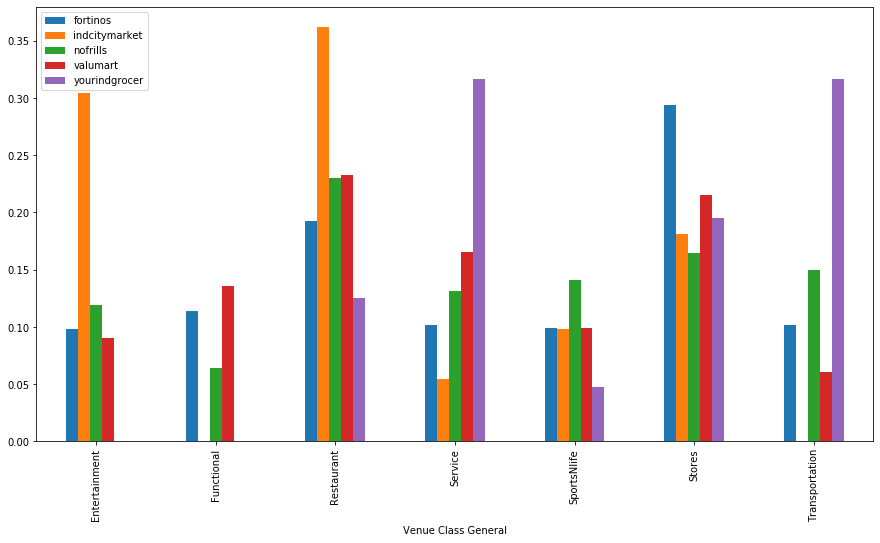

In [53]:
store_venue_grouped_tp_general_perc.plot(kind='bar', figsize = (15,8))

In [54]:
def pie_plot(df):
    colors_list = ['red','gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
    fig = plt.figure(figsize=(18,10), dpi=1000) 
    plt_size = (2,3)
    plt_pos = [(0,0),(0,1),(0,2),(1,0),(1,1)]
      
    for col, pos in zip(df.columns,plt_pos):
        values_sort = np.sort(df[col].values)
        values_sort_index = np.argsort(df[col].values)
        explode_list=[0.1 if (i in values_sort_index[-3:]) else 0 for i in range(len(values_sort_index))]
#         print(explode_list)
        ax1 = plt.subplot2grid(plt_size,pos)
        plt.pie(df[col],
                autopct='%1.1f%%', 
                startangle=90,    
                shadow=False,       
                labels=None,         # turn off labels on pie chart
                pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                colors=colors_list,  # add custom colors
                explode=explode_list # 'explode' highest 3 venue categories
                )
        # add title
        plt.title(col)
        # add legend    
        plt.figlegend(labels=df.index, 
                      loc='lower right',
                      bbox_to_anchor=(0.7, 0.1),
                      fontsize = 'large') 
    plt.suptitle('Percentage of Venue Categories for Each Banner')     
    plt.show()

In [55]:
pie_plot(store_venue_grouped_tp_general_perc)

A table to show the top general venue categories for all banners

In [56]:
store_venue_cat_general_sorted = pd.DataFrame(index = range(1,len(store_venue_grouped_tp_general_perc)+1))
for col in store_venue_grouped_tp_general_perc.columns:
    store_venue_cat_general_sorted[col] = pd.Series(store_venue_grouped_tp_general_perc[col].sort_values(ascending=False).index.to_list(), index = range(1,len(store_venue_grouped_tp_general_perc)+1))

store_venue_cat_general_sorted.to_csv('C:/Users/Daniel_Liang/Documents/JupyterNotebook_docs/IBM_DS_Capstone/Report/Tables/store_venue_general_top10.csv')

store_venue_cat_general_sorted

fortinos   indcitymarket        nofrills        valumart  \
1          Stores      Restaurant      Restaurant      Restaurant   
2      Restaurant   Entertainment          Stores          Stores   
3      Functional          Stores  Transportation         Service   
4  Transportation     SportsNlife     SportsNlife      Functional   
5         Service         Service         Service     SportsNlife   
6     SportsNlife  Transportation   Entertainment   Entertainment   
7   Entertainment      Functional      Functional  Transportation   

    yourindgrocer  
1  Transportation  
2         Service  
3          Stores  
4      Restaurant  
5     SportsNlife  
6      Functional  
7   Entertainment

From the pie charts and the table that shows the top general venue categories for each banner, it can be seen that Stores, Restaurant, and Transportation are common top general venue categories among the banners. When developing classification models, these three categories can be given more weight factor than the others.

### 3.2 ROI Venues Analysis

In [57]:
ROI_venue_grouped = ROI_onehot.groupby('Neighborhood').mean().reset_index()
print(ROI_venue_grouped.shape)
ROI_venue_grouped.head()

(42, 115)


Neighborhood  Adult Boutique  American Restaurant  \
0      Cambridge  South             0.0                  0.0   
1  Cambridge  Southwest             0.0                  0.0   
2       Cambridge  West             0.0                  0.0   
3    Kitchener  Central             0.0                  0.0   
4       Kitchener  East             0.0                  0.0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                  0.0               0.0            0.000000          0.0   
1                  0.0               0.0            0.000000          0.0   
2                  0.0               0.0            0.333333          0.0   
3                  0.0               0.0            0.000000          0.0   
4                  0.0               0.0            0.000000          0.0   

   Baby Store  Bakery  Bank  ...  Toy / Game Store  Trail  Tree  Tunnel  \
0         0.0     0.0   0.0  ...               0.0    0.0   0.0     0.0   
1         0.0     0.0   0.0  ...               0.0    0.0   0.0     0.0   
2         0.0     0.0   0.0  ...               0.0    0.0   0.0     0.0   
3         0.0     0.0   0.0  ...               0.0    0.0   0.0     0.0   
4         0.0     0.0   0.0  ...               0.0    0.0   0.0     0.0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Vineyard  \
0                            0.0                    0.0       0.0   
1                            0.0                    0.0       0.0   
2                            0.0                    0.0       0.0   
3                            0.0                    0.0       0.0   
4                            0.0                    0.0       0.0   

   Wings Joint  Women's Store  Yoga Studio  
0          0.0            0.0          0.0  
1          0.0            0.0          0.0  
2          0.0            0.0          0.0  
3          0.0            0.0          0.0  
4          0.0            0.0          0.0  

[5 rows x 115 columns]

Categorize the venue classes in a more general way using the general venue categories defined in the previous section, and reorganize columns and drop the original venue class column.

In [58]:
### Add left venue classes into the general class
Restaurant_add = ['Soup']
Entertainment_add = ['Recreation']
Stores_add=[]
SportsNlife_add = ['Museum','Outdoor','Tree','Vineyard','Harbor']
Service_add = ['Auto Garage','Office','Lawyer']
Transportation_add=[]
Functional_add=[]
venue_class_add = {'Restaurant':Restaurant_add, 'Entertainment':Entertainment_add, 'Stores':Stores_add, 'SportsNlife':SportsNlife_add, 'Service':Service_add, 'Transportation':Transportation_add, 'Functional':Functional_add}
###
for item in venue_class_add.items():
    if any(item[1]):
        for elem in item[1]:
            venue_classes[item[0]].append(elem)
###

In [59]:
ROI_venue_grouped_tp = ROI_venue_grouped.T.reset_index()
ROI_venue_grouped_tp.columns = ['Venue Class'] + ROI_venue_grouped_tp.iloc[0,1:].to_list()
ROI_venue_grouped_tp = ROI_venue_grouped_tp.iloc[1:]
left_class=[]
for ind, row in ROI_venue_grouped_tp.iterrows():
    check_any = []
    for v_cls in venue_classes.items():
        if any([(i in row['Venue Class']) for i in v_cls[1]]):
            ROI_venue_grouped_tp.loc[ind,'Venue Class General'] = v_cls[0]
            check_any.append('matched')
            break
    if any(check_any):
         continue
    else:
        left_class.append(row['Venue Class'])
        
if any(left_class): # Check if there is unclassified venues
    print('There are unclassified venues, please check and enrich the general class. If the category is not important, leave it.')
    print('Left venue class(es) is: ',left_class)
   
columns = [ROI_venue_grouped_tp.columns[-1]]+list(ROI_venue_grouped_tp.columns[1:-1])
ROI_venue_grouped_tp = ROI_venue_grouped_tp[columns]
ROI_venue_grouped_tp.head()

There are unclassified venues, please check and enrich the general class. If the category is not important, leave it.
Left venue class(es) is:  ['Cemetery', 'College Cafeteria', 'Multiplex', 'Racetrack', 'Tunnel']


Venue Class General Cambridge  South Cambridge  Southwest Cambridge  West  \
1              Stores                0                    0               0   
2          Restaurant                0                    0               0   
3              Stores                0                    0               0   
4          Restaurant                0                    0               0   
5         SportsNlife                0                    0        0.333333   

  Kitchener  Central Kitchener  East Kitchener  North Central  \
1                  0               0                        0   
2                  0               0                        0   
3                  0               0                        0   
4                  0               0                        0   
5                  0               0                        0   

  Kitchener  Northeast Kitchener  Northwest Kitchener  South  ...  \
1                    0                    0                0  ...   
2                    0                    0                0  ...   
3                    0                    0                0  ...   
4                    0                    0                0  ...   
5                    0                    0                0  ...   

  Windsor  (East Forest Glade ) Windsor  (East Riverside )  \
1                             0                          1   
2                             0                          0   
3                             0                          0   
4                             0                          0   
5                             0                          0   

  Windsor  (Riverside ) Windsor  (Roseland )  \
1                     0                    0   
2                     0                    0   
3                     0                    0   
4                     0                    0   
5                     0                    0   

  Windsor  (South Walkerville / West Fontainbleu / Walker Farm / Devonshire )  \
1                                                  0                            
2                                                  0                            
3                                                  0                            
4                                                  0                            
5                                                  0                            

  Windsor  (University / South Cameron )  \
1                                      0   
2                                      0   
3                                      0   
4                                      0   
5                                      0   

  Windsor  (West Forest Glade / East Fontainbleu )  \
1                                                0   
2                                                0   
3                                                0   
4                                                0   
5                                                0   

  Windsor  East (East Walkerville ) Windsor  South  (East Malden )  \
1                                 0                              0   
2                                 0                              0   
3                                 0                              0   
4                                 0                              0   
5                                 0                              0   

  Windsor  South Central  (West Walkerville / Remington Park )  
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            
5                                                  0            

[5 rows x 43 columns]

In [60]:
ROI_venue_grouped_tp['Venue Class General'].value_counts()

Stores            40
Restaurant        30
SportsNlife       19
Entertainment      8
Service            8
Transportation     3
Functional         1
Name: Venue Class General, dtype: int64

In [61]:
ROI_venue_grouped_tp[columns[1:]] = ROI_venue_grouped_tp[columns[1:]].astype('float')
#ROI_venue_grouped_tp.dtypes

In [62]:
ROI_venue_grouped_tp_general = ROI_venue_grouped_tp.groupby('Venue Class General').mean()
# ROI_venue_grouped_tp_general.head()
ROI_venue_grouped_general = ROI_venue_grouped_tp_general.T.reset_index().rename(columns={'index':'Neighborhood'})
ROI_venue_grouped_general.columns.name = '' # remove the column name property
ROI_venue_grouped_general.head()

Neighborhood  Entertainment  Functional  Restaurant  Service  \
0      Cambridge  South          0.000         0.0    0.016667      0.0   
1  Cambridge  Southwest          0.000         0.0    0.000000      0.0   
2       Cambridge  West          0.000         0.0    0.000000      0.0   
3    Kitchener  Central          0.000         0.0    0.025000      0.0   
4       Kitchener  East          0.125         0.0    0.000000      0.0   

   SportsNlife   Stores  Transportation  
0     0.000000  0.00000        0.166667  
1     0.000000  0.00000        0.000000  
2     0.035088  0.00000        0.111111  
3     0.000000  0.00625        0.000000  
4     0.000000  0.00000        0.000000

Let's discard some Neighborhoods if their general categories are very scarce, which make them not attractive as potential locations to open a supermarket. We have seen from the Section 3.1 that 'Stores', 'Restaurant', 'Transportation', and 'Entertainment' categories play important roles in having a supermarket nearby. Therefore, any neighborhood that has none of these four categories around will be removed from our list.

In [63]:
ROI_venue_grouped_general_clean = ROI_venue_grouped_general
for ind, row in ROI_venue_grouped_general.iterrows():
    if not any([row.Stores,row.Entertainment,row.Restaurant,row.Transportation]):
#         print(ind, [row.Stores,row.Entertainment,row.Restaurant,row.Transportation])
        ROI_venue_grouped_general_clean = ROI_venue_grouped_general_clean.drop(ind,0)
ROI_venue_grouped_general_clean = ROI_venue_grouped_general_clean.reset_index(drop=True)
ROI_venue_grouped_general_clean

Neighborhood  Entertainment  \
0                                    Cambridge  South       0.000000   
1                                     Cambridge  West       0.000000   
2                                  Kitchener  Central       0.000000   
3                                     Kitchener  East       0.125000   
4                            Kitchener  North Central       0.000000   
5                                Kitchener  Northeast       0.000000   
6                                Kitchener  Northwest       0.000000   
7                                    Kitchener  South       0.031250   
8                            Kitchener  South Central       0.002976   
9                                Kitchener  Southwest       0.000000   
10                                    Kitchener  West       0.000000   
11                           LaSalle  East (Windsor )       0.000000   
12                              London  (East Tempo )       0.000000   
13  London  (Riverbend / Woodhull / North Sharon C...       0.000000   
14  London  (Southcrest / East Westmount / West Hi...       0.041667   
15  London  (Sunningdale / West Masonville / Medwa...       0.000000   
16            London  (West Huron Heights / Carling )       0.000000   
17  London  (YXU / North and East Argyle / East Hu...       0.000000   
18                                    London  Central       0.006579   
19         London  East  (SW Argyle / Hamilton Road )       0.000000   
20                              London  North  (UWO )       0.016667   
21  London  South  (East Highland / North White Oa...       0.000000   
22                                     Waterloo  East       0.000000   
23                                    Waterloo  South       0.026316   
24                                Waterloo  Southeast       0.000000   
25                                Waterloo  Southwest       0.000000   
26                                            Windsor       0.000000   
27                      Windsor  (East Forest Glade )       0.041667   
28                         Windsor  (East Riverside )       0.000000   
29                              Windsor  (Riverside )       0.000000   
30                               Windsor  (Roseland )       0.000000   
31  Windsor  (South Walkerville / West Fontainbleu...       0.000000   
32             Windsor  (University / South Cameron )       0.000000   
33   Windsor  (West Forest Glade / East Fontainbleu )       0.000000   
34                  Windsor  East (East Walkerville )       0.000000   
35                     Windsor  South  (East Malden )       0.000000   
36  Windsor  South Central  (West Walkerville / Re...       0.000000   

    Functional  Restaurant   Service  SportsNlife    Stores  Transportation  
0     0.000000    0.016667  0.000000     0.000000  0.000000        0.166667  
1     0.000000    0.000000  0.000000     0.035088  0.000000        0.111111  
2     0.000000    0.025000  0.000000     0.000000  0.006250        0.000000  
3     0.000000    0.000000  0.000000     0.000000  0.000000        0.000000  
4     0.000000    0.016667  0.000000     0.013158  0.006250        0.000000  
5     0.000000    0.016667  0.062500     0.000000  0.000000        0.000000  
6     0.000000    0.016667  0.013393     0.001880  0.008929        0.000000  
7     0.000000    0.000000  0.000000     0.013158  0.012500        0.000000  
8     0.023810    0.011111  0.002976     0.001253  0.014286        0.000000  
9     0.000000    0.000000  0.062500     0.000000  0.012500        0.000000  
10    0.000000    0.008333  0.000000     0.013158  0.012500        0.000000  
11    0.000000    0.000000  0.000000     0.000000  0.000000        0.333333  
12    0.000000    0.000000  0.000000     0.000000  0.000000        0.333333  
13    0.000000    0.000000  0.000000     0.026316  0.012500        0.000000  
14    0.000000    0.000000  0.041667     0.000000  0.008333        0.000000  
15    0.000000    0.008333  0.000000     0.026316  0.006

Let's add the 'Borough' back to the dataframe in order to group the general venue features by the Boroughs - KWC, London, and Windsor, and to do EDA based on the Boroughs

In [64]:
ROI_venue_grouped_general_clean_borough = ROI_venue_grouped_general_clean.merge(df_neighbor_roi_grouped[['Neighborhood','Borough']], on = 'Neighborhood', how = 'left')
ROI_venue_grouped_general_clean_borough_group = ROI_venue_grouped_general_clean_borough.groupby('Borough').mean()

ROI_venue_grouped_general_clean_borough_group_perc = ROI_venue_grouped_general_clean_borough_group.T#.reset_index()

for col_i in range(len(ROI_venue_grouped_general_clean_borough_group.T.columns)):
    ROI_venue_grouped_general_clean_borough_group_perc.iloc[:,col_i] = ROI_venue_grouped_general_clean_borough_group_perc.iloc[:,col_i]/ROI_venue_grouped_general_clean_borough_group_perc.iloc[:,col_i].sum()

#ROI_venue_grouped_general_clean_borough_group_perc.to_csv('C:/Users/Daniel_Liang/Documents/JupyterNotebook_docs/IBM_DS_Capstone/Report/Tables/ROI_venue_general_perc.csv')
ROI_venue_grouped_general_clean_borough_group_perc  

Borough              KWC    London   Windsor
Entertainment   0.133681  0.084003  0.036600
Functional      0.051464  0.000000  0.000000
Restaurant      0.100143  0.068149  0.045384
Service         0.101855  0.150412  0.049411
SportsNlife     0.071255  0.142077  0.089382
Stores          0.076022  0.123990  0.120415
Transportation  0.465580  0.431369  0.658807

In [65]:
def pie_plot_ROI(df):
    colors_list = ['red','gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
    fig = plt.figure(figsize=(18,10), dpi=1000) 
    plt_size = (1,3)
    plt_pos = [(0,0),(0,1),(0,2)]
      
    for col, pos in zip(df.columns,plt_pos):
        values_sort = np.sort(df[col].values)
        values_sort_index = np.argsort(df[col].values)
        explode_list=[0.1 if (i in values_sort_index[-3:]) else 0 for i in range(len(values_sort_index))]
#         print(explode_list)
        ax1 = plt.subplot2grid(plt_size,pos)
        plt.pie(df[col],
                autopct='%1.1f%%', 
                startangle=90,    
                shadow=False,       
                labels=None,         # turn off labels on pie chart
                pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                colors=colors_list,  # add custom colors
                explode=explode_list # 'explode' highest 3 venue categories
                )
        # add title
        plt.title(col)
        # add legend    
        plt.figlegend(labels=df.index, 
                      loc='lower right',
                      bbox_to_anchor=(0.6, 0.1),
                      fontsize = 'large') 
    plt.suptitle('Percentage of Venue Categories for Each Borough in the ROI')     
    plt.show()

In [66]:
pie_plot_ROI(ROI_venue_grouped_general_clean_borough_group_perc)

## 4. Modelling
### 4.1 Build a Classification Model to Predict the Appropriate Banner Given General Venue Categories
#### 4.1.1 K-nearest Neighbours (KNN)

In [67]:
# import necessary scikit learn modules 

import itertools

from sklearn import preprocessing
from sklearn.model_selection import train_test_split as tts

# Classification modules 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


# Evaluation modules
from sklearn import metrics
from sklearn.metrics import accuracy_score as J_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score as jacscore
from sklearn.metrics import log_loss

Let's first reorganize the store onehot dataframe and convert the venue classes to more general ones same as what was done in Section 3.1. However, we are not going to group it by the banners since we need the banners as labels for our classification modelling. Since the store onehot dataframe contains all venues in the records, let's group them by the stores and separate them into feature and label dataframes.

In [68]:
store_onehot_group_features = store_onehot.groupby('Neighborhood').mean()
store_onehot_group_labels = store_onehot.groupby('Neighborhood')[['Banner']].first()

Convert venue classes in the features dataframe to more general ones

In [69]:
store_onehot_group_features_tp = store_onehot_group_features.T.reset_index()
store_onehot_group_features_tp.columns = ['Venue Class'] + store_onehot_group_features_tp.columns.to_list()[1:]
left_class=[]
for ind, row in store_onehot_group_features_tp.iterrows():
    check_any = []
    for v_cls in venue_classes.items():
        if any([(i in row['Venue Class']) for i in v_cls[1]]):
            store_onehot_group_features_tp.loc[ind,'Venue Class General'] = v_cls[0]
            check_any.append('matched')
            break
    if any(check_any):
         continue
    else:
        left_class.append(row['Venue Class'])
        
if any(left_class): # Check if there is unclassified venues
    print('There are unclassified venues, please check and enrich the general class. If the category is not important, leave it.')
    print('Left venue class(es) is: ',left_class)
   
columns = [store_onehot_group_features_tp.columns[-1]]+list(store_onehot_group_features_tp.columns[1:-1])
store_onehot_group_features_tp = store_onehot_group_features_tp[columns]
# print(store_onehot_group_features_tp.shape)
store_onehot_group_features_tp = store_onehot_group_features_tp.dropna() # remove records with 
# print(store_onehot_group_features_tp.shape)
store_onehot_group_features_tp = store_onehot_group_features_tp.groupby('Venue Class General').mean()
store_onehot_group_features_general = store_onehot_group_features_tp.T.reset_index()
store_onehot_group_features_general.columns = ['Neighborhood'] + store_onehot_group_features_general.columns.to_list()[1:]
store_onehot_group_features_general = store_onehot_group_features_general.set_index('Neighborhood')
store_onehot_group_features_general.head()

There are unclassified venues, please check and enrich the general class. If the category is not important, leave it.
Left venue class(es) is:  ['Moving Target', 'Platform']


Entertainment  Functional  Restaurant  \
Neighborhood                                                                    
ALI'S NOFRILLS                               0.000000         0.0    0.000000   
ANDREW & SHELLEY’S NOFRILLS NORTH YORK       0.000000         0.0    0.010025   
ANTHONY'S NOFRILLS TORONTO                   0.005013         0.0    0.006002   
ANTHONY'S NOFRILLS VAUGHAN                   0.003401         0.0    0.003759   
ASHLEY'S NOFRILLS MISSISSAUGA                0.000000         0.0    0.004386   

                                         Service  SportsNlife    Stores  \
Neighborhood                                                              
ALI'S NOFRILLS                          0.000000     0.006061  0.003736   
ANDREW & SHELLEY’S NOFRILLS NORTH YORK  0.000000     0.000000  0.005871   
ANTHONY'S NOFRILLS TORONTO              0.002632     0.002632  0.005768   
ANTHONY'S NOFRILLS VAUGHAN              0.000000     0.004762  0.007828   
ASHLEY'S NOFRILLS MISSISSAUGA           0.000000     0.008333  0.003425   

                                        Transportation  
Neighborhood                                            
ALI'S NOFRILLS                                0.060606  
ANDREW & SHELLEY’S NOFRILLS NORTH YORK        0.000000  
ANTHONY'S NOFRILLS TORONTO                    0.000000  
ANTHONY'S NOFRILLS VAUGHAN                    0.000000  
ASHLEY'S NOFRILLS MISSISSAUGA                 0.027778

Join the table of features and labels together

In [70]:
store_onehot_general = store_onehot_group_features_general.merge(store_onehot_group_labels, on = 'Neighborhood')
print(store_onehot_general['Banner'].value_counts())
store_onehot_general.head()

nofrills         55
fortinos         18
valumart         13
yourindgrocer     5
indcitymarket     3
Name: Banner, dtype: int64


Entertainment  Functional  Restaurant  \
Neighborhood                                                                    
ALI'S NOFRILLS                               0.000000         0.0    0.000000   
ANDREW & SHELLEY’S NOFRILLS NORTH YORK       0.000000         0.0    0.010025   
ANTHONY'S NOFRILLS TORONTO                   0.005013         0.0    0.006002   
ANTHONY'S NOFRILLS VAUGHAN                   0.003401         0.0    0.003759   
ASHLEY'S NOFRILLS MISSISSAUGA                0.000000         0.0    0.004386   

                                         Service  SportsNlife    Stores  \
Neighborhood                                                              
ALI'S NOFRILLS                          0.000000     0.006061  0.003736   
ANDREW & SHELLEY’S NOFRILLS NORTH YORK  0.000000     0.000000  0.005871   
ANTHONY'S NOFRILLS TORONTO              0.002632     0.002632  0.005768   
ANTHONY'S NOFRILLS VAUGHAN              0.000000     0.004762  0.007828   
ASHLEY'S NOFRILLS MISSISSAUGA           0.000000     0.008333  0.003425   

                                        Transportation    Banner  
Neighborhood                                                      
ALI'S NOFRILLS                                0.060606  nofrills  
ANDREW & SHELLEY’S NOFRILLS NORTH YORK        0.000000  nofrills  
ANTHONY'S NOFRILLS TORONTO                    0.000000  nofrills  
ANTHONY'S NOFRILLS VAUGHAN                    0.000000  nofrills  
ASHLEY'S NOFRILLS MISSISSAUGA                 0.027778  nofrills

We have seen from the Section 3.1 that 'Stores', 'Restaurant', 'Transportation', and 'Entertainment' categories play important roles in having a supermarket nearby. Therefore, any neighborhood that has none of these four categories around will be removed from our list.

In [71]:
store_onehot_general_clean = store_onehot_general
print(store_onehot_general_clean.shape)
for ind, row in store_onehot_general.iterrows():
    if not any([row.Stores,row.Entertainment,row.Restaurant,row.Transportation]):
#         print(ind, [row.Stores,row.Entertainment,row.Restaurant,row.Transportation])
        store_onehot_general_clean = store_onehot_general_clean.drop(ind,0)
store_onehot_general_clean = store_onehot_general_clean.reset_index(drop=True)
print(store_onehot_general_clean.shape)
print(store_onehot_general_clean['Banner'].value_counts())

(94, 8)
(85, 8)
nofrills         51
fortinos         16
valumart         11
yourindgrocer     5
indcitymarket     2
Name: Banner, dtype: int64


To use scikit-learn library, we have to convert the Pandas data frame to a Numpy array:

In [72]:
X = store_onehot_general_clean[store_onehot_general_clean.columns[:-1]].values
X[0:5]

array([[0.        , 0.        , 0.        , 0.        , 0.00606061,
        0.00373599, 0.06060606],
       [0.        , 0.        , 0.01002506, 0.        , 0.        ,
        0.00587084, 0.        ],
       [0.00501253, 0.        , 0.00600185, 0.00263158, 0.00263158,
        0.00576784, 0.        ],
       [0.00340136, 0.        , 0.0037594 , 0.        , 0.0047619 ,
        0.00782779, 0.        ],
       [0.        , 0.        , 0.00438596, 0.        , 0.00833333,
        0.00342466, 0.02777778]])

In [73]:
y = store_onehot_general_clean['Banner'].values
y[0:5]

array(['nofrills', 'nofrills', 'nofrills', 'nofrills', 'nofrills'],
      dtype=object)

In [74]:
X_train, X_test, y_train, y_test = tts( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (59, 7) (59,)
Test set: (26, 7) (26,)


In [75]:
k = 4
#Train Model and Predict  
KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [76]:
yhat = KNN.predict(X_test)
print(yhat[0:10])
print(y_test[0:10])

['nofrills' 'nofrills' 'nofrills' 'nofrills' 'nofrills' 'nofrills'
 'nofrills' 'nofrills' 'nofrills' 'valumart']
['nofrills' 'valumart' 'nofrills' 'nofrills' 'nofrills' 'fortinos'
 'nofrills' 'fortinos' 'fortinos' 'valumart']


In [77]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, KNN.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.6779661016949152
Test set Accuracy:  0.5384615384615384


Test of K's

In [78]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    KNN = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=KNN.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.34615385, 0.26923077, 0.46153846, 0.53846154, 0.61538462,
       0.61538462, 0.53846154, 0.53846154, 0.53846154])

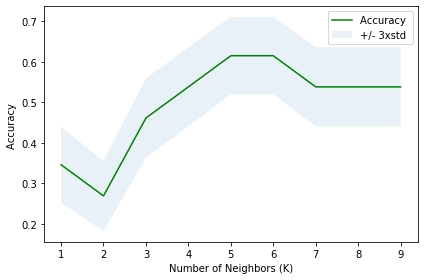

In [79]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [80]:
k = 7
#Train Model and Predict  
KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

#### 4.1.2 Decision Tree

Train-Test split for the Decision Tree training model below

In [81]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=4)
print("train set X size", X_train.shape, "train set y size", y_train.shape)
print("test set X size", X_test.shape, "test set y size", y_test.shape)

train set X size (59, 7) train set y size (59,)
test set X size (26, 7) test set y size (26,)


In [82]:
max_depth = 10
k_acc_DT=[]
for n in range(1,max_depth+1):
    DT = DTC(criterion = 'entropy', max_depth=n)
    DT.fit(X_train,y_train)
    k_acc_DT.append(J_score(y_test, DT.predict(X_test)))
    #print("Jaccard score for the test set using depth of {0} is {1:.3f}".format(n,k_acc_DT[n-1]))

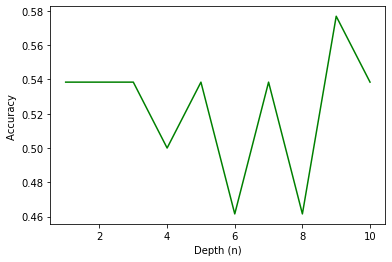

In [83]:
plt.plot(range(1,max_depth+1),k_acc_DT,'g')
plt.ylabel('Accuracy ')
plt.xlabel('Depth (n)')
plt.show()

In [84]:
max_depth = 3
DT = DTC(criterion = 'entropy', max_depth=max_depth)
DT.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### 4.1.3 Support Vector Machine

In [85]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=4)
print("train set X size", X_train.shape, "train set y size", y_train.shape)
print("test set X size", X_test.shape, "test set y size", y_test.shape)

train set X size (59, 7) train set y size (59,)
test set X size (26, 7) test set y size (26,)


In [86]:
Banner_SVC = SVC(kernel='rbf')
Banner_SVC.fit(X_train,y_train)
y_hat_SVC =Banner_SVC.predict(X_test) 
y_hat_SVC[:5]

array(['nofrills', 'nofrills', 'nofrills', 'nofrills', 'nofrills'],
      dtype=object)

In [87]:
print("f1-score of the SVC model is %.3f" % f1_score(y_test, y_hat_SVC, average='weighted'))
print("jaccard_similarity_score of the SVC model is %.3f" % J_score(y_test, y_hat_SVC))

f1-score of the SVC model is 0.377
jaccard_similarity_score of the SVC model is 0.538


In [88]:
Banner_SVC = SVC(kernel='rbf')
Banner_SVC.fit(X,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### 4.1.4 Logistic Regression

In [89]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=4)
print("train set X size", X_train.shape, "train set y size", y_train.shape)
print("test set X size", X_test.shape, "test set y size", y_test.shape)

train set X size (59, 7) train set y size (59,)
test set X size (26, 7) test set y size (26,)


In [90]:
Banner_LR = LogisticRegression(C=0.01, solver='liblinear')
Banner_LR.fit(X_train,y_train)
yhat_prob = Banner_LR.predict_proba(X_test)

In [91]:
Banner_LR = LogisticRegression(C=0.01, solver='liblinear')
Banner_LR.fit(X,y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### 4.2 Banner Classification Model Evaluation 

KNN evaluations

In [92]:
y_hat = KNN.predict(X_test)
J_KNN = J_score(y_test, y_hat)
print("Jaccard score for the test set using KNN with k = {0} is {1:.3f}".format(6,J_KNN))
F1_KNN = f1_score(y_test, y_hat, average='weighted')
print("F1 score for the test set using KNN with k = {0} is {1:.3f}".format(6,F1_KNN))

Jaccard score for the test set using KNN with k = 6 is 0.538
F1 score for the test set using KNN with k = 6 is 0.377


Decision-tree evaluations

In [93]:
y_hat = DT.predict(X_test)
J_DT = J_score(y_test, y_hat)
print("Jaccard score for the test set using DT with depth = {0} is {1:.3f}".format(7,J_DT))
F1_DT = f1_score(y_test, y_hat, average='weighted')
print("F1 score for the test set using DT with depth = {0} is {1:.3f}".format(7,F1_DT))

Jaccard score for the test set using DT with depth = 7 is 0.538
F1 score for the test set using DT with depth = 7 is 0.387


Support Vector Machines evaluations

In [94]:
y_hat = Banner_SVC.predict(X_test)
J_SVC = J_score(y_test, y_hat)
print("Jaccard score for the test set using SVC is {0:.3f}".format(J_SVC))
F1_SVC = f1_score(y_test, y_hat, average='weighted')
print("F1 score for the test set using SVC is {0:.3f}".format(F1_SVC))

Jaccard score for the test set using SVC is 0.538
F1 score for the test set using SVC is 0.377


Logistic Regression evaluations

In [95]:
y_hat = Banner_LR.predict(X_test)
y_hat_prob = Banner_LR.predict_proba(X_test)
J_LR = J_score(y_test, y_hat)
print("Jaccard score for the test set using LR is {0:.3f}".format(J_LR))
F1_LR = f1_score(y_test, y_hat, average='weighted')
print("F1 score for the test set using LR is {0:.3f}".format(F1_LR))
Logloss_LR = log_loss(y_test, y_hat_prob, labels =['fortinos', 'indcitymarket' ,'nofrills', 'valumart','yourindgrocer'])
print("Logloss score for the test set using LR is {0:.3f}".format(Logloss_LR))

Jaccard score for the test set using LR is 0.538
F1 score for the test set using LR is 0.377
Logloss score for the test set using LR is 1.542


Combined report for the evaluations using difference models

In [96]:
Jaccard_ls = [J_KNN,J_DT,J_SVC,J_LR]
F1_ls = [F1_KNN,F1_DT,F1_SVC,F1_LR]
LogLoss_ls = [np.nan,np.nan,np.nan, Logloss_LR]
label_score = ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression']
score_dic = {'Algorithm':label_score, 'Jaccard':Jaccard_ls, 'F1-score':F1_ls, 'LogLoss':LogLoss_ls}
Eval_Report_df = pd.DataFrame(score_dic).set_index('Algorithm')

Eval_Report_df.to_csv('C:/Users/Daniel_Liang/Documents/JupyterNotebook_docs/IBM_DS_Capstone/Report/Tables/class_model_eval.csv')

Eval_Report_df

Jaccard  F1-score   LogLoss
Algorithm                                       
KNN                 0.538462  0.376923       NaN
Decision Tree       0.538462  0.386588       NaN
SVM                 0.538462  0.376923       NaN
LogisticRegression  0.538462  0.376923  1.541598

### 4.3 Build a Clustering Model to Group the Neiborghhoods in the ROI

In [97]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [98]:
# set number of clusters
kclusters = 5

ROI_grouped_clustering = ROI_venue_grouped_general_clean.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(init = 'k-means++', n_clusters=kclusters, random_state=0, n_init =12).fit(ROI_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([0, 0, 1, 3, 1, 4, 1, 1, 1, 4, 1, 2, 2, 1, 4, 1, 4, 1, 4, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 4, 4])

In [99]:
ROI_venue_grouped_general_cluster = ROI_venue_grouped_general_clean.copy(deep = False)
ROI_venue_grouped_general_cluster.insert(0, 'Cluster Labels', kmeans.labels_)
#ROI_venue_grouped_general_clean
ROI_venue_grouped_general_cluster_coord = ROI_venue_grouped_general_cluster.merge(df_neighbor_roi_grouped, how='left', on = 'Neighborhood')
ROI_venue_grouped_general_cluster_coord.head()

Cluster Labels              Neighborhood  Entertainment  Functional  \
0               0          Cambridge  South          0.000         0.0   
1               0           Cambridge  West          0.000         0.0   
2               1        Kitchener  Central          0.000         0.0   
3               3           Kitchener  East          0.125         0.0   
4               1  Kitchener  North Central          0.000         0.0   

   Restaurant  Service  SportsNlife   Stores  Transportation Postcode Borough  \
0    0.016667      0.0     0.000000  0.00000        0.166667      N1P     KWC   
1    0.000000      0.0     0.035088  0.00000        0.111111      N3H     KWC   
2    0.025000      0.0     0.000000  0.00625        0.000000      N2G     KWC   
3    0.000000      0.0     0.000000  0.00000        0.000000      N2A     KWC   
4    0.016667      0.0     0.013158  0.00625        0.000000      N2H     KWC   

  Latitude Longitude  
0  43.3398  -80.2955  
1  43.4267  -80.3699  
2  43.4443  -80.4891  
3  43.4413  -80.4246  
4  43.4581  -80.4818

In [100]:
ROI_venue_grouped_general_cluster_grouped = ROI_venue_grouped_general_cluster_coord.groupby('Cluster Labels')[['Entertainment','Functional','Restaurant','Service','SportsNlife','Stores','Transportation']].mean()
ROI_venue_grouped_general_cluster_grouped

Entertainment  Functional  Restaurant   Service  SportsNlife  \
Cluster Labels                                                                 
0                    0.000000    0.000000    0.008333  0.000000     0.011696   
1                    0.005403    0.003247    0.008464  0.000744     0.010397   
2                    0.000000    0.000000    0.000000  0.000000     0.000000   
3                    0.125000    0.000000    0.000000  0.000000     0.000000   
4                    0.006892    0.000000    0.004586  0.042497     0.006661   

                  Stores  Transportation  
Cluster Labels                            
0               0.004167        0.120370  
1               0.012164        0.001595  
2               0.000000        0.333333  
3               0.000000        0.000000  
4               0.008330        0.000000

In [101]:
ROI_venue_grouped_general_cluster_grouped_perc = ROI_venue_grouped_general_cluster_grouped.T#.reset_index()

for col_i in range(len(ROI_venue_grouped_general_cluster_grouped.T.columns)):
    ROI_venue_grouped_general_cluster_grouped_perc.iloc[:,col_i] = ROI_venue_grouped_general_cluster_grouped_perc.iloc[:,col_i]/ROI_venue_grouped_general_cluster_grouped_perc.iloc[:,col_i].sum()

ROI_venue_grouped_general_cluster_grouped_perc.to_csv('C:/Users/Daniel_Liang/Documents/JupyterNotebook_docs/IBM_DS_Capstone/Report/Tables/ROI_cluster_venue_perc.csv')
ROI_venue_grouped_general_cluster_grouped_perc  

Cluster Labels         0         1    2    3         4
Entertainment   0.000000  0.128612  0.0  1.0  0.099935
Functional      0.000000  0.077279  0.0  0.0  0.000000
Restaurant      0.057644  0.201467  0.0  0.0  0.066502
Service         0.000000  0.017710  0.0  0.0  0.616190
SportsNlife     0.080903  0.247456  0.0  0.0  0.096588
Stores          0.028822  0.289514  0.0  0.0  0.120785
Transportation  0.832631  0.037962  1.0  0.0  0.000000

Visualize the clusters in map

In [102]:
address = 'London, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 42.9836747, -81.2496068.


In [103]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ROI_venue_grouped_general_cluster_coord['Latitude'], ROI_venue_grouped_general_cluster_coord['Longitude'], ROI_venue_grouped_general_cluster_coord['Neighborhood'], ROI_venue_grouped_general_cluster_coord['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster) +')', parse_html=True)
    if cluster == 4:
        radius = 10
    else:
        radius = 5
    folium.CircleMarker(
        [lat, lon],
        radius=radius,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 4.4 Apply the Banner Classification Model on the ROI

In [104]:
ROI_venue_grouped_general_cluster_coord_cluster4 = ROI_venue_grouped_general_cluster_coord[ROI_venue_grouped_general_cluster_coord['Cluster Labels'] == 4].reset_index(drop = True)
ROI_venue_grouped_general_cluster_coord_cluster4#.head()

Cluster Labels                                       Neighborhood  \
0               4                               Kitchener  Northeast   
1               4                               Kitchener  Southwest   
2               4  London  (Southcrest / East Westmount / West Hi...   
3               4            London  (West Huron Heights / Carling )   
4               4                                    London  Central   
5               4                     Windsor  South  (East Malden )   
6               4  Windsor  South Central  (West Walkerville / Re...   

   Entertainment  Functional  Restaurant   Service  SportsNlife    Stores  \
0       0.000000         0.0    0.016667  0.062500     0.000000  0.000000   
1       0.000000         0.0    0.000000  0.062500     0.000000  0.012500   
2       0.041667         0.0    0.000000  0.041667     0.000000  0.008333   
3       0.000000         0.0    0.000000  0.041667     0.017544  0.008333   
4       0.006579         0.0    0.008772  0.032895     0.002770  0.007895   
5       0.000000         0.0    0.006667  0.025000     0.000000  0.015000   
6       0.000000         0.0    0.000000  0.031250     0.026316  0.006250   

   Transportation Postcode  Borough Latitude Longitude  
0             0.0      N2B      KWC  43.4646  -80.4467  
1             0.0      N2E      KWC  43.4106  -80.5011  
2             0.0      N6J   London  42.9546  -81.2735  
3             0.0      N5Y   London  43.0123  -81.2307  
4             0.0      N6B   London  42.9835  -81.2386  
5             0.0      N9E  Windsor  42.2652  -83.0314  
6             0.0      N8X  Windsor  42.2926  -83.0186

In [105]:
ROI_feature = ROI_venue_grouped_general_cluster_coord_cluster4[['Entertainment','Functional','Restaurant','Service','SportsNlife','Stores','Transportation']].values

In [106]:
ROI_predicted_banner = KNN.predict(ROI_feature)

In [107]:
ROI_predicted_banner

array(['nofrills', 'nofrills', 'nofrills', 'nofrills', 'nofrills',
       'nofrills', 'nofrills'], dtype=object)

In [108]:
ROI_venue_with_banner = ROI_venue_grouped_general_cluster_coord_cluster4.copy(deep=False)
ROI_venue_with_banner['Suggested Banner'] = ROI_predicted_banner
ROI_venue_with_banner.head()

Cluster Labels                                       Neighborhood  \
0               4                               Kitchener  Northeast   
1               4                               Kitchener  Southwest   
2               4  London  (Southcrest / East Westmount / West Hi...   
3               4            London  (West Huron Heights / Carling )   
4               4                                    London  Central   

   Entertainment  Functional  Restaurant   Service  SportsNlife    Stores  \
0       0.000000         0.0    0.016667  0.062500     0.000000  0.000000   
1       0.000000         0.0    0.000000  0.062500     0.000000  0.012500   
2       0.041667         0.0    0.000000  0.041667     0.000000  0.008333   
3       0.000000         0.0    0.000000  0.041667     0.017544  0.008333   
4       0.006579         0.0    0.008772  0.032895     0.002770  0.007895   

   Transportation Postcode Borough Latitude Longitude Suggested Banner  
0             0.0      N2B     KWC  43.4646  -80.4467         nofrills  
1             0.0      N2E     KWC  43.4106  -80.5011         nofrills  
2             0.0      N6J  London  42.9546  -81.2735         nofrills  
3             0.0      N5Y  London  43.0123  -81.2307         nofrills  
4             0.0      N6B  London  42.9835  -81.2386         nofrills

In [109]:
ROI_venue_with_banner_venues = ROI_venue_with_banner[['Neighborhood','Entertainment','Functional','Restaurant','Service','SportsNlife','Stores','Transportation']].set_index('Neighborhood')
ROI_venue_with_banner_venues_perc = ROI_venue_with_banner_venues.T

for col_i in range(len(ROI_venue_with_banner_venues.T.columns)):
    ROI_venue_with_banner_venues_perc.iloc[:,col_i] = ROI_venue_with_banner_venues_perc.iloc[:,col_i]/ROI_venue_with_banner_venues_perc.iloc[:,col_i].sum()


ROI_venue_with_banner_venues_perc = ROI_venue_with_banner_venues_perc.T
ROI_venue_with_banner_venues_perc
ROI_venue_with_banner_perc = ROI_venue_with_banner.copy(deep=False).set_index('Neighborhood')
ROI_venue_with_banner_perc[['Entertainment','Functional','Restaurant','Service','SportsNlife','Stores','Transportation']] = ROI_venue_with_banner_venues_perc[['Entertainment','Functional','Restaurant','Service','SportsNlife','Stores','Transportation']]
ROI_venue_with_banner_perc.to_csv('C:/Users/Daniel_Liang/Documents/JupyterNotebook_docs/IBM_DS_Capstone/Report/Tables/ROI_venue_with_banner_perc.csv')
ROI_venue_with_banner_perc

Cluster Labels  \
Neighborhood                                                         
Kitchener  Northeast                                             4   
Kitchener  Southwest                                             4   
London  (Southcrest / East Westmount / West Hig...               4   
London  (West Huron Heights / Carling )                          4   
London  Central                                                  4   
Windsor  South  (East Malden )                                   4   
Windsor  South Central  (West Walkerville / Rem...               4   

                                                    Entertainment  Functional  \
Neighborhood                                                                    
Kitchener  Northeast                                     0.000000         0.0   
Kitchener  Southwest                                     0.000000         0.0   
London  (Southcrest / East Westmount / West Hig...       0.454545         0.0   
London  (West Huron Heights / Carling )                  0.000000         0.0   
London  Central                                          0.111677         0.0   
Windsor  South  (East Malden )                           0.000000         0.0   
Windsor  South Central  (West Walkerville / Rem...       0.000000         0.0   

                                                    Restaurant   Service  \
Neighborhood                                                               
Kitchener  Northeast                                  0.210526  0.789474   
Kitchener  Southwest                                  0.000000  0.833333   
London  (Southcrest / East Westmount / West Hig...    0.000000  0.454545   
London  (West Huron Heights / Carling )               0.000000  0.616883   
London  Central                                       0.148903  0.558386   
Windsor  South  (East Malden )                        0.142857  0.535714   
Windsor  South Central  (West Walkerville / Rem...    0.000000  0.489691   

                                                    SportsNlife    Stores  \
Neighborhood                                                                
Kitchener  Northeast                                   0.000000  0.000000   
Kitchener  Southwest                                   0.000000  0.166667   
London  (Southcrest / East Westmount / West Hig...     0.000000  0.090909   
London  (West Huron Heights / Carling )                0.259740  0.123377   
London  Central                                        0.047022  0.134013   
Windsor  South  (East Malden )                         0.000000  0.321429   
Windsor  South Central  (West Walkerville / Rem...     0.412371  0.097938   

                                                    Transportation Postcode  \
Neighborhood                                                                  
Kitchener  Northeast                                           0.0      N2B   
Kitchener  Southwest                                           0.0      N2E   
London  (Southcrest / East Westmount / West Hig...             0.0      N6J   
London  (West Huron Heights / Carling )                        0.0      N5Y   
London  Central                                                0.0      N6B   
Windsor  South  (East Malden )                                 0.0      N9E   
Windsor  South Central  (West Walkerville / Rem...             0.0      N8X   

                                                    Borough Latitude  \
Neighborhood                                                           
Kitchener  Northeast                                    KWC  43.4646   
Kitchener  Southwest                                    KWC  43.4106   
London  (Southcrest / East Westmount / West Hig...   London  42.9546   
London  (West Huron Heights / Carling )              London  43.0123   
London  Central                                      London  42.9835   
Windsor  South  (East Malden )                      Windsor  42.2652   
Windsor  South Central  

In [110]:
picked_neighborhood_outstanding = ['London  North  (UWO )', 'Waterloo  South']
picked_neighborhood_fair = ['Kitchener  Northwest','Kitchener  West','Waterloo  East']
ROI_venue_with_banner_perc_picked = ROI_venue_with_banner_perc[[(i in (picked_neighborhood_outstanding+picked_neighborhood_fair)) for i in ROI_venue_with_banner_perc.index.to_list()]]

ROI_venue_with_banner_perc_picked

Empty DataFrame
Columns: [Cluster Labels, Entertainment, Functional, Restaurant, Service, SportsNlife, Stores, Transportation, Postcode, Borough, Latitude, Longitude, Suggested Banner]
Index: []

In [111]:
# # create map
# map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# # set color scheme for the clusters
# num_suggest_banner = len(np.unique(ROI_predicted_banner))
# x = np.arange(num_suggest_banner)
# ys = [i + x + (i*x)**2 for i in range(num_suggest_banner)]
# colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
# rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add markers to the map
# markers_colors = []
# for lat, lon, poi, cluster, banner in zip(ROI_venue_with_banner['Latitude'], ROI_venue_with_banner['Longitude'], ROI_venue_with_banner['Neighborhood'], ROI_venue_with_banner['Cluster Labels'], ROI_venue_with_banner['Suggested Banner']):
#     label = folium.Popup(str(banner) + ' [' + str(poi) + ']' + ' (Cluster ' + str(cluster) +')', parse_html=True)
#     col_ind = list(np.unique(ROI_predicted_banner)).index(banner)
#     folium.CircleMarker(
#         [lat, lon],
#         radius=5,
#         popup=label,
#         color=rainbow[col_ind],
#         fill=True,
#         fill_color=rainbow[col_ind],
#         fill_opacity=0.7).add_to(map_clusters)
       
# map_clusters

In [112]:
# create map of only the picked neighborhoods
map_picked = folium.Map(location=[latitude, longitude], zoom_start=8)

color_i = ['yellow','green']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, banner in zip(ROI_venue_with_banner_perc_picked['Latitude'], ROI_venue_with_banner_perc_picked['Longitude'], ROI_venue_with_banner_perc_picked.index, ROI_venue_with_banner_perc_picked['Cluster Labels'], ROI_venue_with_banner_perc_picked['Suggested Banner']):
    label = folium.Popup(str(banner) + ' [' + str(poi) + ']', parse_html=True)
    col_ind = list(np.unique(ROI_venue_with_banner_perc_picked['Suggested Banner'].values)).index(banner)
    if poi in picked_neighborhood_outstanding:
        color_index = 0
        radius = 20
    else:
        color_index = 1
        radius = 10
    folium.CircleMarker(
        [lat, lon],
        radius=radius,
        popup=label,
        color='red',
        fill=True,
        fill_color=color_i[color_index],
        fill_opacity=0.8).add_to(map_picked)
       
map_picked